**Desafio**

Você foi alocado em um time da Indicium contratado por um estúdio de Hollywood chamado PProductions, e agora deve fazer uma análise em cima de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. Lembre-se que há muito dinheiro envolvido, então a análise deve ser muito detalhada e levar em consideração o máximo de fatores possíveis (a introdução de dados externos é permitida - e encorajada).

**Dados Externos**
- Decidi pegar variaveis externas utilizando uma API da TMDB, coletei informações sobre a linguagem utilizada, orçamento dos filmes e keywords. 
- Também peguei um banco de dados sobre o Oscar pra poder trazer na base de dados a relação de se um ator ou diretor possuia oscar antes de fazer o filme em questão, se isso influenciava. 

**Separação**
- os estão dispostos da seguinte forma: 
    - Carregando Dados tem o merge de todas as variaveis e preparação de um mesmo dataset. 
    - Limpeza e Tratamento dos dados tem toda a preparação dos dados para o EDA
    - EDA: Avaliação visual para compreensão da disposição dos dados
        - variável alvo: análises acerca do IMDb
        - exploração da estrutura dos dados: a visualização de como os dados estão dispostos em relação ao ano, aos generos, a classificação etc.
    - Hipóteses traz os testes em relação ao que foi visto no EDA e também ao que poderia se supor sobre a base de dados.
    - Perguntas são as 3 perguntas do desafio: 
        - Qual filme você recomendaria para uma pessoa que você não conhece?
        - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 
        - Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
    - Explicações está os modelos preditivos do IMDb
    - Suposição de Filme com características específicas é o teste do modelo que foi treinado com um dado fora do dataset. 
    - Adendo: nesse tópico eu trago uma rutura temporal devido a ter um desequilíbrio na base, em que antes de 1990 os dados se comportam de uma forma e posterior de outra. Ali eu coloco pesos de tempo, e dummies tentando minimizar esse viés e também tentando alcançar um bom modelo preditivo. 

# **Carregando os dados**

In [59]:

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, f_oneway
from scipy.sparse import hstack, csr_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    f1_score, classification_report
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBRegressor


In [60]:
tabela = pd.read_csv('desafio_indicium_imdb.csv')
tabela.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [61]:
oscars = pd.read_csv('the_oscar_award.csv')
oscars.head()

,year_film,year_ceremony,ceremony,category,canon_category,name,film,winner
0,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Patent Leather Kid,False
2,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Way of All Flesh,True
4,1927,1928,1,ACTRESS,ACTRESS IN A LEADING ROLE,Louise Dresser,A Ship Comes In,False


Essa base de dados do Oscar eu consegui no Kaggle, neste link: https://www.kaggle.com/datasets/unanimad/the-oscar-award

In [62]:
complementares = pd.read_csv('complementares.csv')
complementares.head()

,row_index,query_title,query_year,tmdb_id,matched_title,original_title,release_date,budget_usd,revenue_usd,profit_usd,...,vote_count,popularity,genres,keywords,status,original_language,imdb_id,homepage,found,_error
0,0,The Godfather,1972.0,238.0,The Godfather,The Godfather,1972-03-14,6000000.0,2.450664e+08,2.390664e+08,...,21771.0,27.4415,"Drama, Crime","based on novel or book, loss of loved one, lov...",Released,en,tt0068646,http://www.thegodfather.com/,True,NaN
1,1,The Dark Knight,2008.0,155.0,The Dark Knight,The Dark Knight,2008-07-16,185000000.0,1.004558e+09,8.195584e+08,...,34300.0,31.0804,"Drama, Action, Crime, Thriller","sadism, chaos, secret identity, crime fighter,...",Released,en,tt0468569,https://www.warnerbros.com/movies/dark-knight/,True,NaN
2,2,The Godfather: Part II,1974.0,240.0,The Godfather Part II,The Godfather Part II,1974-12-20,13000000.0,1.026000e+08,8.960000e+07,...,13143.0,15.7352,"Drama, Crime","new year's eve, new york city, based on novel ...",Released,en,tt0071562,NaN,True,NaN
3,3,12 Angry Men,1957.0,389.0,12 Angry Men,12 Angry Men,1957-04-10,397751.0,4.360000e+06,3.962249e+06,...,9355.0,14.3753,Drama,"death penalty, anonymity, court case, court, j...",Released,en,tt0050083,NaN,True,NaN
4,4,The Lord of the Rings: The Return of the King,2003.0,122.0,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,2003-12-17,94000000.0,1.118889e+09,1.024889e+09,...,25395.0,23.9887,"Adventure, Fantasy, Action","army, based on novel or book, elves, dwarf, ma...",Released,en,tt0167260,http://www.lordoftherings.net,True,NaN


Esse conjunto de dados complementares peguei no site tmdb, pela API deles

In [63]:
# criando uma lista pra salvar os nomes das classes
classes = []

#vau olhar cada valor da coluna canon_category
for cat in oscars["canon_category"]:
    # se for vazio coloca nada
    if pd.isna(cat):
        classes.append(None)
    else:
        #deixa o texto em maiusculo pra comparar
        c = str(cat).upper()
        # se tiver escrito actor ou actress eu falo q é ator
        if "ACTOR" in c or "ACTRESS" in c:
            classes.append("ATOR")
        # se tiver escrito direct eu falo q é diretor
        elif "DIRECT" in c:
            classes.append("DIRETOR")
        # se nao for nada disso eu coloco filme
        else:
            classes.append("FILME")

# criando uma coluna nova com a lista q eu fiz
oscars["category_3class"] = classes

#exibri
print(oscars["category_3class"].value_counts(dropna=False))


category_3class
FILME      8091
ATOR       1855
DIRETOR    1164
Name: count, dtype: int64


In [64]:
#Aqui eu estou fazendo alguns tratamentos nas duas tabelas para que possa dar merge, visto que estão com nome diferente de variavel.
##Primeiro vou transformar em numerico oq não for vira NaN, mas fica type float
tabela['Released_Year'] = pd.to_numeric(tabela['Released_Year'], errors='coerce')
##O valor que está nulo em Released_Year é do filme Apollo 13 de Tom Hanks, que foilançado em 1995, sendo assim o irei imputar.
tabela['Released_Year'].fillna(1995, inplace=True)
#Agora força ele a virar INT64, já q não tem mais NaN
tabela['Released_Year'] = tabela['Released_Year'].astype('int64')


#Agora iremos padronizar a escrita para poder dar "merge"
##tabela
tabela['Series_Title'] = (tabela['Series_Title'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
tabela['Director'] = (tabela['Director'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
tabela['Star1'] = (tabela['Star1'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
tabela['Star2'] = (tabela['Star2'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
tabela['Star3'] = (tabela['Star3'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
tabela['Star4'] = (tabela['Star4'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))

##oscars
oscars['film'] = (oscars['film'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
oscars['year_film'] = oscars['year_film'].astype('Int64')
oscars['name'] = (oscars['name'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
oscars['winner'] = oscars['winner'].fillna(False).astype(bool)

##complementares 
complementares['query_title'] = (complementares['query_title'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
complementares['query_year'] = complementares['query_year'].astype('Int64')
complementares['budget_usd'] = complementares['budget_usd'].astype('float')
complementares['keywords'] = (complementares['keywords'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))
complementares['original_language'] = (complementares['original_language'].astype(str).str.lower().str.strip().str.replace(r'\s+', ' ', regex=True))

# classificar em 3 classes oscars
def map_to_3classes(category):
    if pd.isna(category):
        return None
    c = str(category).upper()
    if "ACTOR" in c or "ACTRESS" in c:
        return "ACTOR"
    if "DIRECT" in c:
        return "DIRECTOR"
    return "FILM"

oscars['canon_category'] = oscars['canon_category'].map(map_to_3classes)

#função auxiliar para classificar se os atores e diretores já tinham oscar antes do filme ser lançado
def ganhou_oscar_antes(nome, ano, categoria):
    dados = oscars[(oscars['name'] == nome) & 
                   (oscars['canon_category'] == categoria) & 
                   (oscars['winner']) & 
                   (oscars['year_film'] <= ano)]
    return int(not dados.empty)

tabela['Star1_OscarActor_Winner'] = tabela.apply(lambda row: ganhou_oscar_antes(row['Star1'], row['Released_Year'], 'ACTOR'), axis=1)
tabela['Star2_OscarActor_Winner'] = tabela.apply(lambda row: ganhou_oscar_antes(row['Star2'], row['Released_Year'], 'ACTOR'), axis=1)
tabela['Star3_OscarActor_Winner'] = tabela.apply(lambda row: ganhou_oscar_antes(row['Star3'], row['Released_Year'], 'ACTOR'), axis=1)
tabela['Star4_OscarActor_Winner'] = tabela.apply(lambda row: ganhou_oscar_antes(row['Star4'], row['Released_Year'], 'ACTOR'), axis=1)

tabela['Director_OscarDirector_Winner'] = tabela.apply(lambda row: ganhou_oscar_antes(row['Director'], row['Released_Year'], 'DIRECTOR'), axis=1)

#oscars do filme
def filme_oscar_info(titulo):
    dados = oscars[
        (oscars['film'] == titulo) &
        (oscars['winner'])
    ]
    return int(not dados.empty), len(dados)

#aplicar em toda a tabela
tabela[['Filme_OscarWinner','Filme_OscarCount']] = tabela['Series_Title'].apply(
    lambda t: pd.Series(filme_oscar_info(t))
)

#remover a coluna "Unnamed: 0" 
if 'Unnamed: 0' in tabela.columns:
    tabela = tabela.drop(columns=['Unnamed: 0'])

tabela = tabela.merge(complementares[['query_title', 'query_year', 'budget_usd', 'original_language', 'keywords']],
    left_on=['Series_Title', 'Released_Year'],
    right_on=['query_title', 'query_year'],
    how='left'
).drop(columns=['query_title', 'query_year']) \
 .rename(columns={
     'budget_usd': 'Budget_USD',
     'original_language': 'Original_Language',
     'keywords': 'Keywords'
 })

tabela.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Star1_OscarActor_Winner,Star2_OscarActor_Winner,Star3_OscarActor_Winner,Star4_OscarActor_Winner,Director_OscarDirector_Winner,Filme_OscarWinner,Filme_OscarCount,Budget_USD,Original_Language,Keywords
0,the godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,francis ford coppola,marlon brando,...,1,0,0,0,0,1,3,6000000.0,en,"based on novel or book, loss of loved one, lov..."
1,the dark knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,christopher nolan,christian bale,...,0,1,0,1,0,1,2,185000000.0,en,"sadism, chaos, secret identity, crime fighter,..."
2,the godfather: part ii,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,francis ford coppola,al pacino,...,0,1,0,0,1,0,0,13000000.0,en,"new year's eve, new york city, based on novel ..."
3,12 angry men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,sidney lumet,henry fonda,...,0,0,0,0,0,0,0,397751.0,en,"death penalty, anonymity, court case, court, j..."
4,the lord of the rings: the return of the king,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,peter jackson,elijah wood,...,0,0,0,0,1,1,11,94000000.0,en,"army, based on novel or book, elves, dwarf, ma..."


# **Limpeza e Tratamento dos dados**

## Identificando duplicados

In [65]:
#Verificando se há valores duplicados
tabela.duplicated().sum()

0

Ótimo, o 0 representa que não temos duplicatas.

## Alterando tipo de variável

In [66]:
tabela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Series_Title                   999 non-null    object 
 1   Released_Year                  999 non-null    int64  
 2   Certificate                    898 non-null    object 
 3   Runtime                        999 non-null    object 
 4   Genre                          999 non-null    object 
 5   IMDB_Rating                    999 non-null    float64
 6   Overview                       999 non-null    object 
 7   Meta_score                     842 non-null    float64
 8   Director                       999 non-null    object 
 9   Star1                          999 non-null    object 
 10  Star2                          999 non-null    object 
 11  Star3                          999 non-null    object 
 12  Star4                          999 non-null    obj

In [67]:
#Alterar o tipo das variaveis:

#Variável Realesed_Year
##Essa está em int e iremos transformar em datetime, nessa transformação assume-se 1° de janeiro
tabela['Released_Year'] = pd.to_datetime(tabela['Released_Year'], format='%Y', errors='coerce')

#Variável Runtime
##Essa variável tem o complemento 'min' no final, então tiraremos esse e iremos transformar em número inteiro
tabela['Runtime'] = (tabela['Runtime'].str.replace('min', '', regex=False).astype(float))

#Variável Gross
tabela['Gross'] = (tabela['Gross'].replace('[\$,]', '', regex=True))
#Converte para número e coloca NaN no que não for número
tabela['Gross'] = pd.to_numeric(tabela['Gross'], errors='coerce')

tabela['Budget_USD'] = (tabela['Budget_USD'].replace('[\$,]', '', regex=True))
tabela['Budget_USD']  = pd.to_numeric(tabela['Budget_USD'],  errors='coerce')

#Variável Genre
##Essa variável está com vários gêneros em uma mesma célula, sendo assim, iremos fazer get dummies com one hot enconding pra poder avaliar esses generos separadamente
generos_dummies = tabela['Genre'].str.get_dummies(sep=', ')
tabela = pd.concat([tabela, generos_dummies], axis=1)

# Variável original_language
## Essa variável está um idioma por flme, então usamos get_dummies
idiomas_dummies = pd.get_dummies(tabela['Original_Language'], prefix='lang', drop_first=True)
tabela = pd.concat([tabela, idiomas_dummies], axis=1)



In [68]:
#achar filmes com budget nulo ou zero
problemas = tabela[(tabela["Budget_USD"].isna()) | (tabela["Budget_USD"] == 0)]

print("filmes com budget zerado ou nulo:", len(problemas))
print(problemas[["Series_Title","Released_Year","Gross","Budget_USD"]].head(20))


filmes com budget zerado ou nulo: 155
                          Series_Title Released_Year      Gross  Budget_USD
19                     soorarai pottru    2020-01-01        NaN         0.0
29                             seppuku    1962-01-01        NaN         0.0
54                        vikram vedha    2017-01-01        NaN         0.0
55                      kimi no na wa.    2016-01-01  5017246.0         0.0
75                               anand    1971-01-01        NaN         0.0
84                             tumbbad    2018-01-01        NaN         0.0
88             jodaeiye nader az simin    2011-01-01  7098492.0         0.0
90                miracle in cell no.7    2019-01-01        NaN         0.0
91                      babam ve oglum    2005-01-01        NaN         0.0
104                       idi i smotri    1985-01-01        NaN         0.0
120                              ikiru    1952-01-01    55240.0         0.0
124  m - eine stadt sucht einen mörder    1931-01-

In [69]:
#Aqui to alterando o Certificate pra maiuscula
tabela['Certificate'] = tabela['Certificate'].astype(str).str.strip().str.upper()

#Trocando "U/A" por "UA"
tabela['Certificate'] = tabela['Certificate'].str.replace("U/A", "UA")

#Voltando valores "NAN" para NaN
tabela.loc[tabela['Certificate'] == "NAN", 'Certificate'] = pd.NA

print(tabela['Certificate'].unique())
print(tabela['Certificate'].value_counts(dropna=False))



['A' 'UA' 'U' 'PG-13' 'R' <NA> 'PG' 'G' 'PASSED' 'TV-14' '16' 'TV-MA'
 'UNRATED' 'GP' 'APPROVED' 'TV-PG']
Certificate
U           234
A           196
UA          176
R           146
<NA>        101
PG-13        43
PG           37
PASSED       34
G            12
APPROVED     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
UNRATED       1
Name: count, dtype: int64


In [70]:
#Vamos verificar a distribuição dos valores numéricos
tabela.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Star1_OscarActor_Winner,Star2_OscarActor_Winner,Star3_OscarActor_Winner,Star4_OscarActor_Winner,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
count,999,999.000000,999.000000,842.000000,9.990000e+02,8.300000e+02,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,1991-03-21 19:46:18.378378368,122.871872,7.947948,77.969121,2.716214e+05,6.808257e+07,0.163163,0.126126,0.074074,0.048048,...,0.032032,0.035035,0.017017,0.099099,0.125125,0.067067,0.019019,0.137137,0.051051,0.020020
min,1920-01-01 00:00:00,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1976-01-01 00:00:00,103.000000,7.700000,70.000000,5.547150e+04,3.245338e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1999-01-01 00:00:00,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2009-01-01 00:00:00,137.000000,8.100000,87.000000,3.731675e+05,8.087634e+07,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020-01-01 00:00:00,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,28.101227,0.272290,12.383257,3.209126e+05,1.098076e+08,0.369700,0.332158,0.262023,0.213975,...,0.176173,0.183960,0.129399,0.298945,0.331026,0.250263,0.136660,0.344164,0.220212,0.140139


## Tratando dados nulos (missing)

In [71]:
tabela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 76 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Series_Title                   999 non-null    object        
 1   Released_Year                  999 non-null    datetime64[ns]
 2   Certificate                    898 non-null    object        
 3   Runtime                        999 non-null    float64       
 4   Genre                          999 non-null    object        
 5   IMDB_Rating                    999 non-null    float64       
 6   Overview                       999 non-null    object        
 7   Meta_score                     842 non-null    float64       
 8   Director                       999 non-null    object        
 9   Star1                          999 non-null    object        
 10  Star2                          999 non-null    object        
 11  Star3              

In [72]:
tabela.isna().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
                ... 
lang_ta            0
lang_te            0
lang_tr            0
lang_uz            0
lang_zh            0
Length: 76, dtype: int64

Aqui podemos perceber que há valores nulos na tabela, nas variaveis: Certificate (101), Meta_score (157) e Gross (169). Meta-score é a média ponderada de todas as críticas. Gross é o faturamento. Certificate é a classficação etária. São valores bem expressivos dado o conjunto de dados que possuímos, sendo assim, iremos análisar a forma adequada de realizar o tratamento. Nas colunas de orçamento, keywords e idioma original irei fazer a pesquisa dessas informações no IMDb novamente para substituir as que estão faltosas na hora do tratamento dos dados.

In [73]:
tabela[tabela['Budget_USD'].isna()][['Series_Title','Released_Year']]

,Series_Title,Released_Year
252,fa yeung nin wah,2000-01-01
965,apollo 13,1995-01-01


In [74]:
tabela[tabela['Original_Language'].isna()][['Series_Title','Released_Year']]

,Series_Title,Released_Year
965,apollo 13,1995-01-01


In [75]:
tabela[tabela['Keywords'].isna()][['Series_Title','Released_Year']]

,Series_Title,Released_Year
965,apollo 13,1995-01-01


In [76]:
#usando chave do ano e titulo pra poder substituir 
yr = pd.to_datetime(tabela['Released_Year'], errors='coerce').dt.year
m_apollo = (tabela['Series_Title'] == 'apollo 13') & (yr == 1995)
m_mood   = (tabela['Series_Title'] == 'fa yeung nin wah') & (yr == 2000)

#os valores da keywords
apollo_kw = ('space exploration, astronaut, accident, survival, malfunction, rescue, '
             'houston, apollo mission, mission control, lunar module, curiosity, challenge')

#agr ta preenchendo tudo q faltava
tabela.loc[m_apollo, ['Original_Language','Keywords','Budget_USD']] = ['en', apollo_kw, 52_000_000]
tabela.loc[m_mood, 'Budget_USD'] = 3_000_000


Decidi tratar os valores nulos de Meta Score e Gross agrupando eles por genero principal, então o primeiro item da lista (ou seja, o primeiro antes da vírgula) na coluna Genero foi selecionado para o agrupamento. Ao analisar o grupo Ação, por exemplo, estimei a media de faturamento e media de avaliação/criticas desse gênero e imputei nos valores nulos. O restante, que não havia como imputar, coloquei a mediana global.

In [77]:
#pego o genero principal q é o primeiro da lista
tabela["Genero_Principal"] = tabela["Genre"].str.split(",").str[0].str.strip()

#calcula a media do gross pra cada genero
media_gross_por_genero = tabela.groupby("Genero_Principal")["Gross"].mean()

#preenche os valores vazios do gross com a media do genero
tabela["Gross"] = tabela["Gross"].fillna(tabela["Genero_Principal"].map(media_gross_por_genero))

# se ainda sobrar vazio coloco a mediana geral do gross
mediana_global_gross = tabela["Gross"].median(skipna=True)
tabela["Gross"] = tabela["Gross"].fillna(mediana_global_gross)


In [78]:
#clculo a media do meta_score pra cada genero
media_meta_por_genero = tabela.groupby("Genero_Principal")["Meta_score"].mean()

#preencher os valores vazios do meta_score com a media do genero
tabela["Meta_score"] = tabela["Meta_score"].fillna(tabela["Genero_Principal"].map(media_meta_por_genero))

#se ainda sobrar vazio coloco a mediana geral do meta_score
mediana_global_meta = tabela["Meta_score"].median(skipna=True)
tabela["Meta_score"] = tabela["Meta_score"].fillna(mediana_global_meta)

tabela.isna().sum()

Series_Title          0
Released_Year         0
Certificate         101
Runtime               0
Genre                 0
                   ... 
lang_te               0
lang_tr               0
lang_uz               0
lang_zh               0
Genero_Principal      0
Length: 77, dtype: int64

## Feature

In [79]:
#criar a variavel profit
tabela["Profit"] = tabela["Gross"] - tabela["Budget_USD"]

#ver as primeiras linhas pra conferir
print(tabela[["Series_Title", "Profit"]].head())


                                    Series_Title       Profit
0                                  the godfather  128966411.0
1                                the dark knight  349858444.0
2                         the godfather: part ii   44300000.0
3                                   12 angry men    3962249.0
4  the lord of the rings: the return of the king  283845905.0


# **EDA**

## Variável alvo

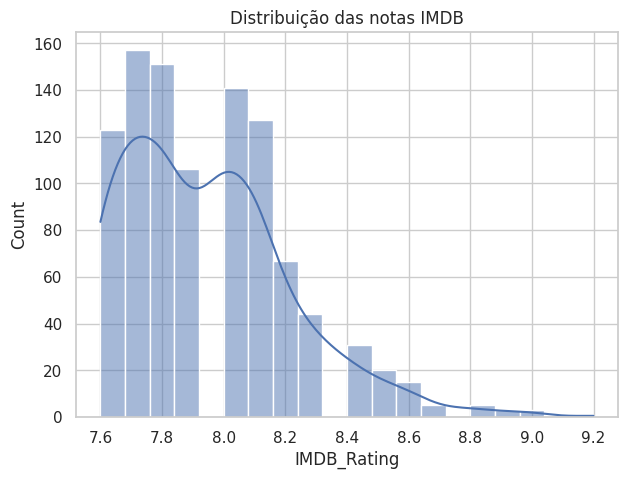

In [80]:
sns.histplot(tabela['IMDB_Rating'], bins=20, kde=True)
plt.title("Distribuição das notas IMDB")
plt.show()

A maioria dos filmes tem notas entre 7.6 e 8.2, com pico em torno de 7.8. Poucos chegam acima de 8.5, mostrando que notas muito altas são raras.

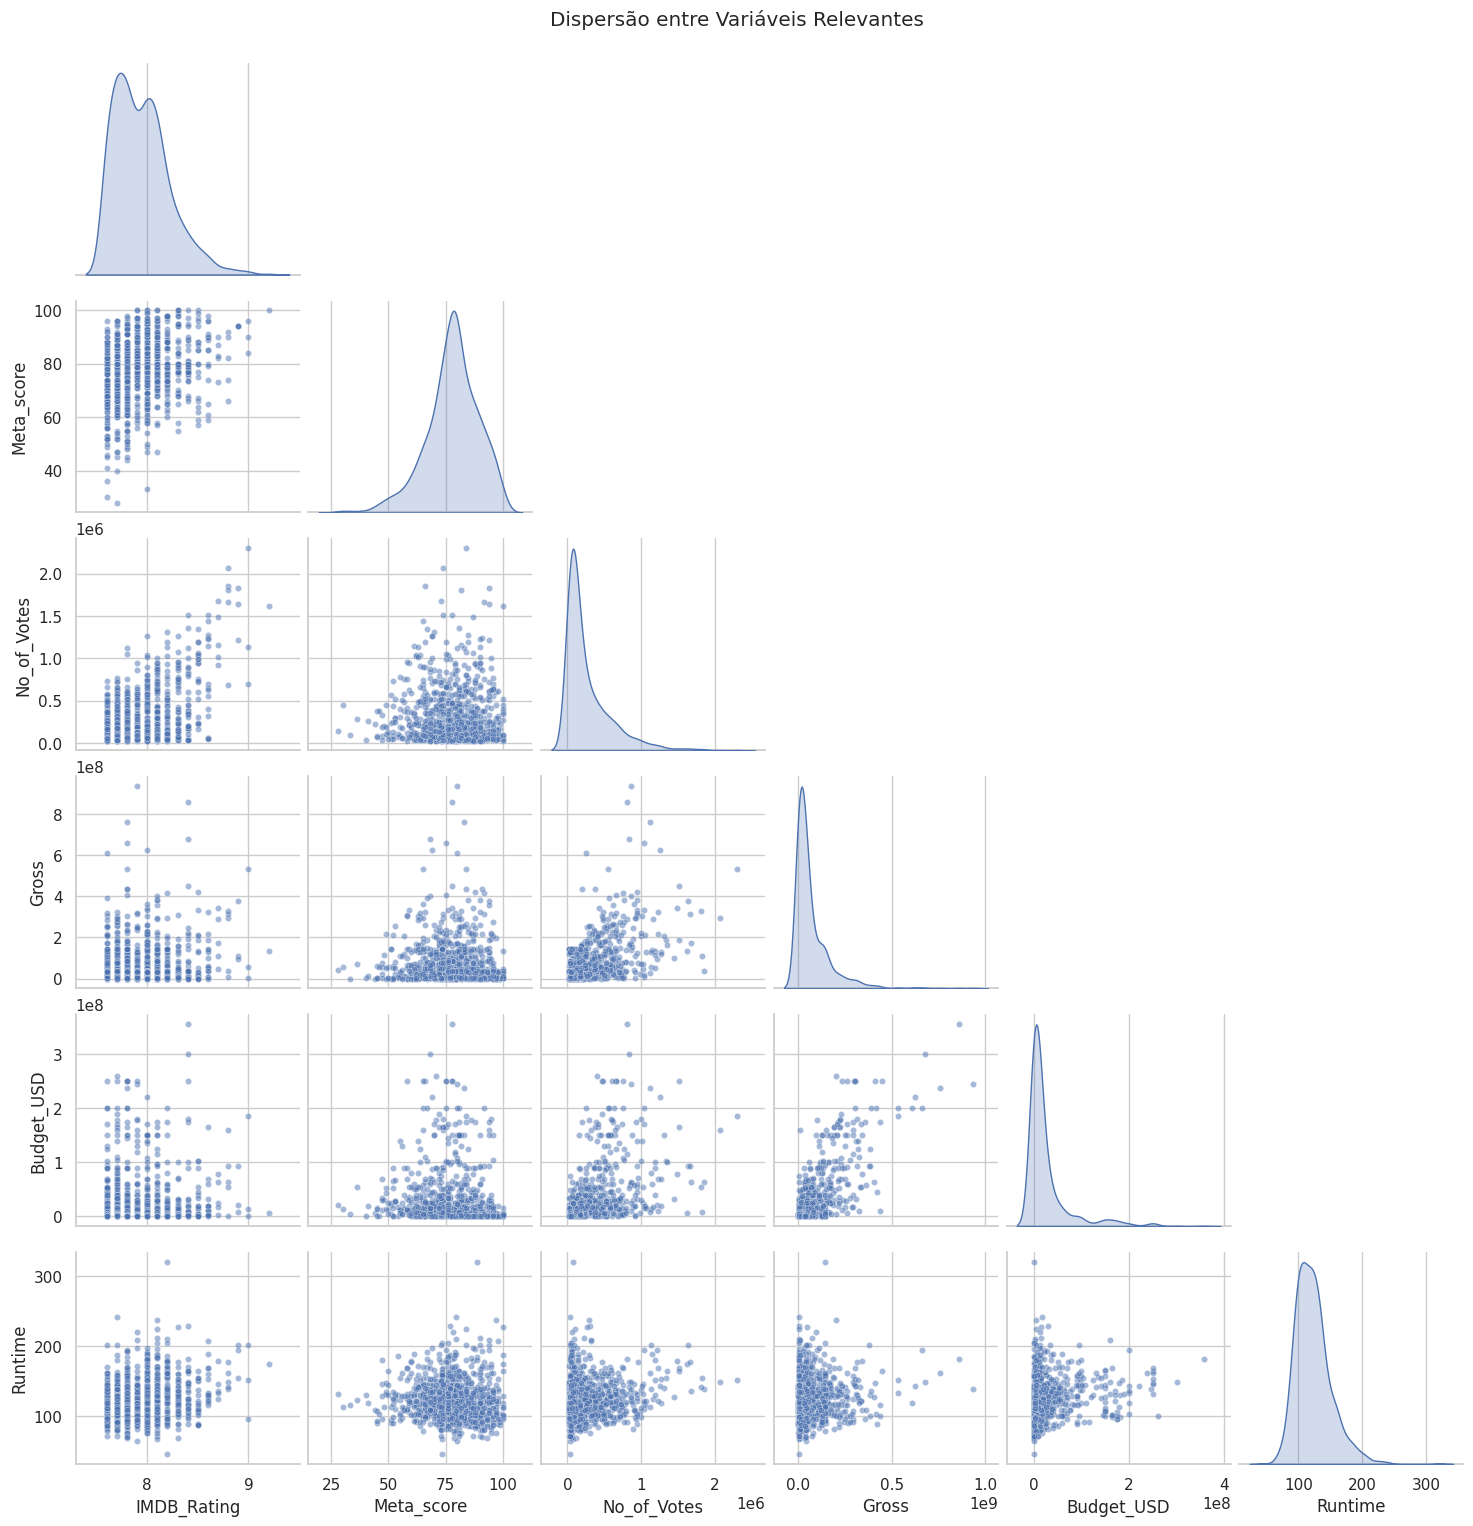

In [81]:
# Selecionar apenas colunas relevantes (tirando gêneros e Oscars de atores)
subset = tabela[['IMDB_Rating','Meta_score','No_of_Votes','Gross','Budget_USD','Runtime']]

# Pairplot
sns.pairplot(subset, diag_kind="kde", corner=True, plot_kws={"alpha":0.5, "s":20})
plt.suptitle("Dispersão entre Variáveis Relevantes", y=1.02)
plt.show()

os filmes que tem mais votos acabam ficando com notas mais estaveis no imdb, ja o orcamento maior geralmente puxa junto uma bilheteria maior. a duracao do filme e as notas da critica nao mostram um padrao muito claro com o resto.

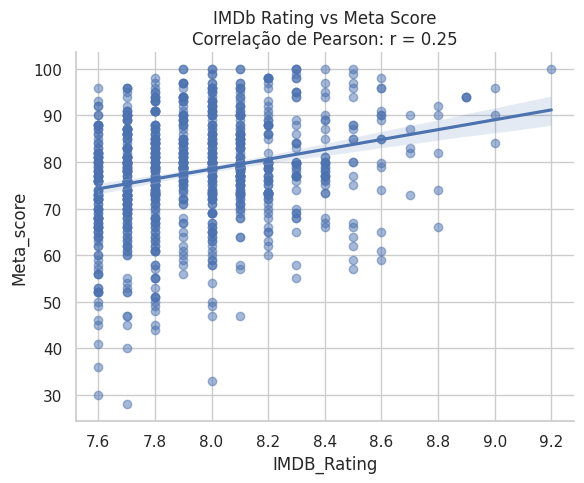

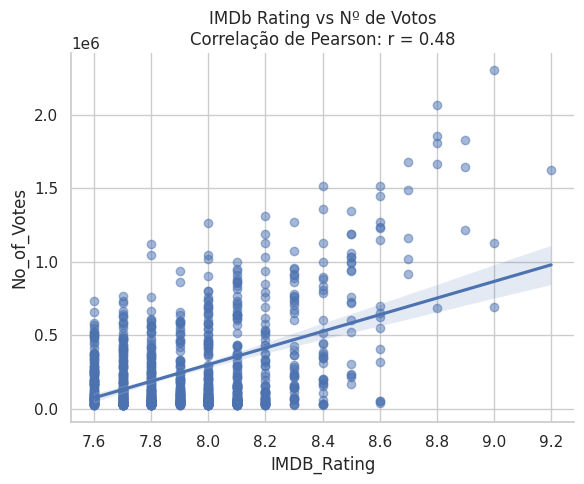

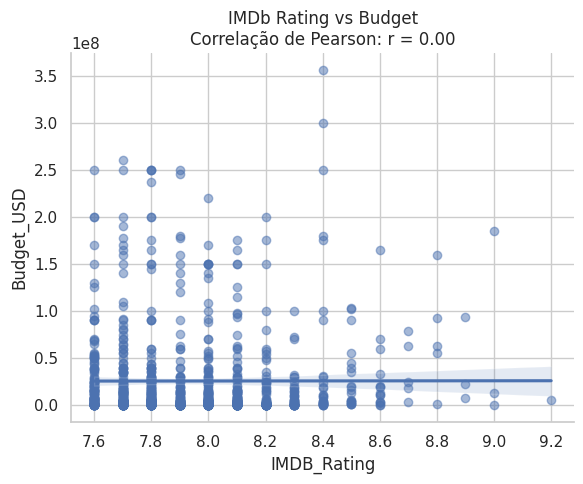

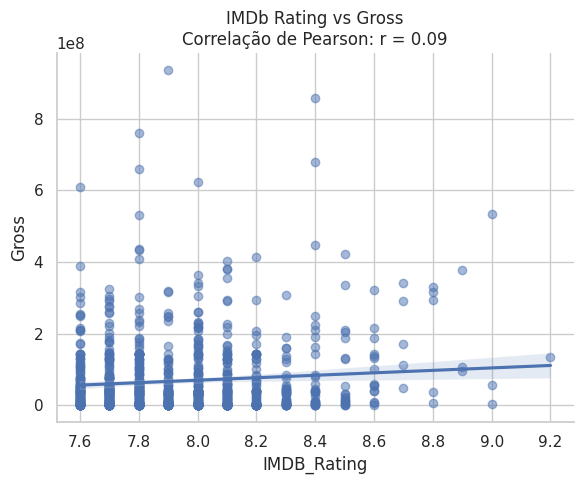

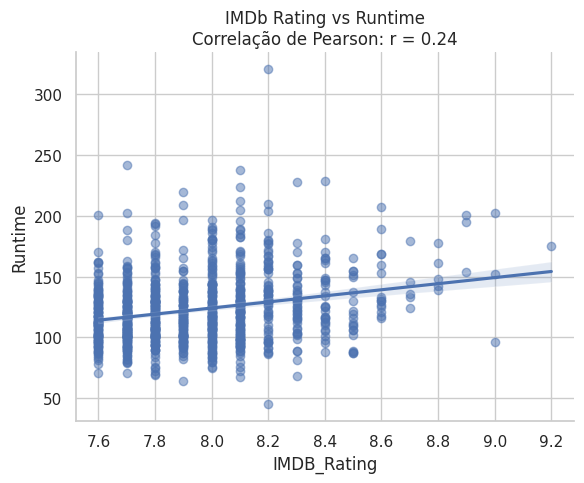

In [82]:
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (7, 5)

def plot_scatter_with_corr(x_col, y_col, data, title_prefix):
    r, _ = pearsonr(data[x_col], data[y_col])
    sns.lmplot(x=x_col, y=y_col, data=data, aspect=1.2, height=5, scatter_kws={'alpha':0.5})
    plt.title(f'{title_prefix}\nCorrelação de Pearson: r = {r:.2f}')
    plt.tight_layout()
    plt.show()

# 1. IMDb Rating vs Meta Score
plot_scatter_with_corr('IMDB_Rating', 'Meta_score', tabela, 'IMDb Rating vs Meta Score')

# 2. IMDb Rating vs Nº de Votos
plot_scatter_with_corr('IMDB_Rating', 'No_of_Votes', tabela, 'IMDb Rating vs Nº de Votos')

# 3. IMDb Rating vs Budget
plot_scatter_with_corr('IMDB_Rating', 'Budget_USD', tabela, 'IMDb Rating vs Budget')

# 4. IMDb Rating vs Gross
plot_scatter_with_corr('IMDB_Rating', 'Gross', tabela, 'IMDb Rating vs Gross')

# 6. IMDb Rating vs Runtime
plot_scatter_with_corr('IMDB_Rating', 'Runtime', tabela, 'IMDb Rating vs Runtime')


as notas do imdb tem uma ligação fraca com o meta score e também com o tempo de duração dos filmes, mas nada muito forte. a relação que aparece mais clara é com o número de votos, mostrando que filmes bem avaliados costumam ter mais público engajado. já o orçamento e a bilheteria praticamente não influenciam na nota, gastar mais ou arrecadar mais não garante uma avaliação melhor.

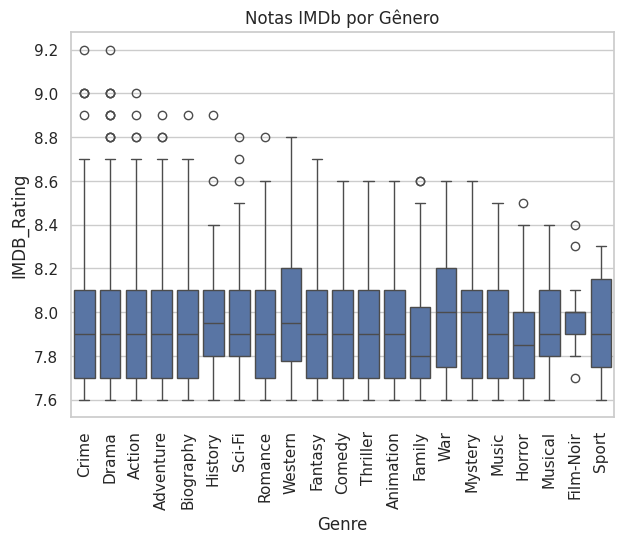

In [83]:
# Explodir gêneros em linhas (um filme pode ter mais de 1)
tabela_exploded = tabela.assign(Genre=tabela['Genre'].str.split(', ')).explode('Genre')

# Boxplot simples
sns.boxplot(data=tabela_exploded, x='Genre', y='IMDB_Rating')
plt.xticks(rotation=90)
plt.title("Notas IMDb por Gênero")
plt.show()

as notas do imdb ficam bem proximas entre os generos, a maioria variando entre 7.7 e 8.1. crime, drama e biography puxam um pouco mais pra cima, com varios filmes chegando perto de 9. ja generos como horror, musical e animation costumam ter medias mais baixas, mostrando que agradam menos em geral.

## Exploração da estrutura dos dados

In [84]:
# Contagem de idiomas
idiomas_count = tabela['Original_Language'].value_counts(dropna=False)

print(idiomas_count)


Original_Language
en     698
hi      54
ja      48
fr      44
it      21
de      20
es      18
ko      14
sv      12
tr      10
ru      10
da       8
cn       6
zh       5
pt       4
fa       4
nl       3
ta       3
te       2
sr       2
ar       2
id       2
et       1
sh       1
ml       1
nan      1
ga       1
ro       1
bs       1
uz       1
kn       1
Name: count, dtype: int64


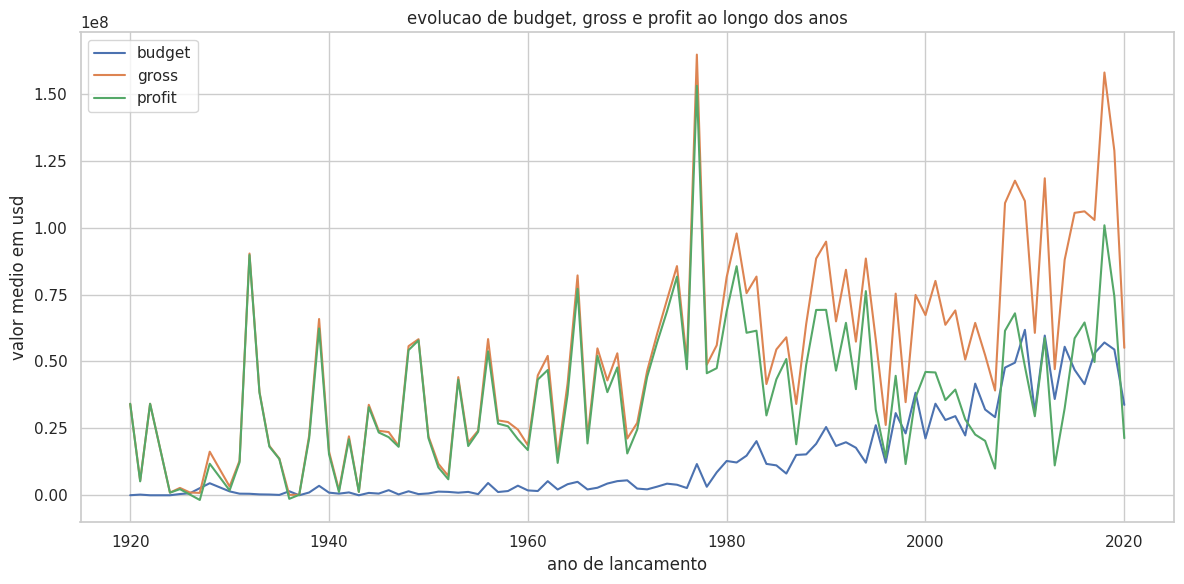

In [85]:
#agrupar por ano e calcular medias
df_anos = tabela.groupby("Released_Year")[["Budget_USD","Gross","Profit"]].mean().reset_index()

#plotar linhas
plt.figure(figsize=(12,6))
plt.plot(df_anos["Released_Year"], df_anos["Budget_USD"], label="budget")
plt.plot(df_anos["Released_Year"], df_anos["Gross"], label="gross")
plt.plot(df_anos["Released_Year"], df_anos["Profit"], label="profit")

plt.xlabel("ano de lancamento")
plt.ylabel("valor medio em usd")
plt.title("evolucao de budget, gross e profit ao longo dos anos")
plt.legend()
plt.tight_layout()
plt.show()


O gráfico mostra a evolução do orçamento (budget), da receita bruta (gross) e do lucro estimado (profit) ao longo dos anos de lançamento dos filmes.  
Nota-se que a partir de 1970 os valores aumentam, mas as oscilações em gross e profit são muito acentuadas. Esse comportamento pode refletir tanto filmes de grande sucesso quanto problemas de consistência nos dados, já que a base não possui registros uniformes em todas as décadas.  
Além disso, há um volume muito maior de filmes lançados após 1990, o que tende a tornar as médias mais estáveis nesse período, em contraste com os anos anteriores em que poucos filmes registrados fazem com que os valores médios oscilem bastante.  
Portanto, os resultados precisam ser interpretados com cautela, pois parte das variações pode estar associada às limitações da base de dados e não apenas a mudanças reais no mercado cinematográfico.


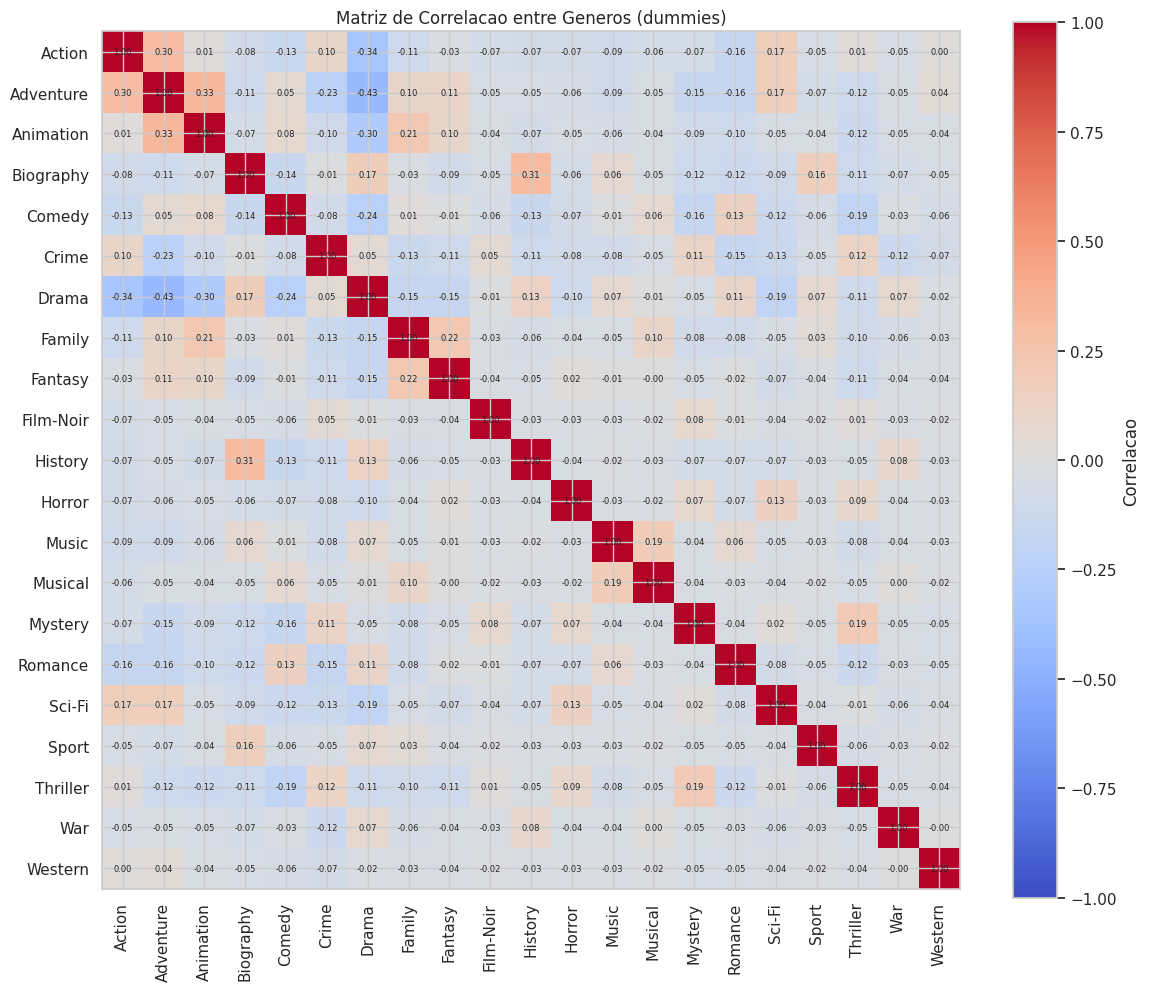


Top 5 correlacoes positivas:
  Genero1   Genero2  Correlacao
Adventure Animation    0.329782
Biography   History    0.305528
   Action Adventure    0.295528
   Family   Fantasy    0.215486
Animation    Family    0.212490

Top 5 correlacoes negativas:
  Genero1 Genero2  Correlacao
Adventure   Drama   -0.433211
   Action   Drama   -0.341705
Animation   Drama   -0.304570
   Comedy   Drama   -0.241533
Adventure   Crime   -0.229326


In [86]:
# pego so colunas q comecam com nome dos generos (ajusta conforme suas colunas)
genre_cols = [c for c in tabela.columns if c in [
    "Action","Adventure","Animation","Biography","Comedy","Crime","Drama","Family",
    "Fantasy","Film-Noir","History","Horror","Music","Musical","Mystery","Romance",
    "Sci-Fi","Sport","Thriller","War","Western"
]]

genero_dummies = tabela[genre_cols]

# matriz de correlacao
corr_generos = genero_dummies.corr()

# plotar heatmap
plt.figure(figsize=(12,10))
plt.imshow(corr_generos, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlacao")
plt.xticks(range(len(genre_cols)), genre_cols, rotation=90)
plt.yticks(range(len(genre_cols)), genre_cols)
plt.title("Matriz de Correlacao entre Generos (dummies)")
for i in range(len(corr_generos)):
    for j in range(len(corr_generos)):
        plt.text(j, i, f"{corr_generos.iloc[i,j]:.2f}", ha="center", va="center", fontsize=6)
plt.tight_layout()
plt.show()

# ranking sem repeticao
corr_pairs = (
    corr_generos.where(~np.eye(corr_generos.shape[0], dtype=bool))
    .where(np.triu(np.ones(corr_generos.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Genero1","Genero2","Correlacao"]

# ordenar
top5 = corr_pairs.sort_values("Correlacao", ascending=False).head(5)
bottom5 = corr_pairs.sort_values("Correlacao", ascending=True).head(5)

print("\nTop 5 correlacoes positivas:")
print(top5.to_string(index=False))

print("\nTop 5 correlacoes negativas:")
print(bottom5.to_string(index=False))


as maiores correlações aparecem entre drama, action e adventure, que costumam andar juntos em muitos filmes. também se destaca a ligação de biography com history, o que faz sentido pelo tema parecido. já alguns generos como horror, musical e film-noir quase não se relacionam com os demais, mostrando que aparecem mais isolados.

In [87]:
#seleciona apenas as colunas numericas
num_cols = tabela.select_dtypes(include='number')

#matriz de correlação
corr = num_cols.corr()

#deixa só a parte triangular superior 
corr_unstacked = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

#transforma em série
corr_pairs = corr_unstacked.unstack().dropna()

#ordena pelos mais fortes 
corr_sorted = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

# Mostra top 10
print("Top correlações mais fortes:")
print(corr_sorted.head(10))


Top correlações mais fortes:
Profit            Gross                            0.905485
Budget_USD        Gross                            0.749003
Filme_OscarCount  Filme_OscarWinner                0.748209
Gross             No_of_Votes                      0.554287
Filme_OscarCount  Director_OscarDirector_Winner    0.541023
Budget_USD        No_of_Votes                      0.522541
No_of_Votes       IMDB_Rating                      0.479308
Adventure         Budget_USD                       0.478456
                  Gross                            0.440677
Drama             Adventure                       -0.433211
dtype: float64


as correlações mais fortes mostram que quanto maior o orçamento, maior tende a ser a bilheteria, e filmes que arrecadam mais também costumam ter mais votos no imdb. além disso, filmes de aventura aparecem ligados a altos orçamentos e faturamentos. já o drama tem correlação negativa com aventura e ação, indicando que esses gêneros raramente aparecem juntos.

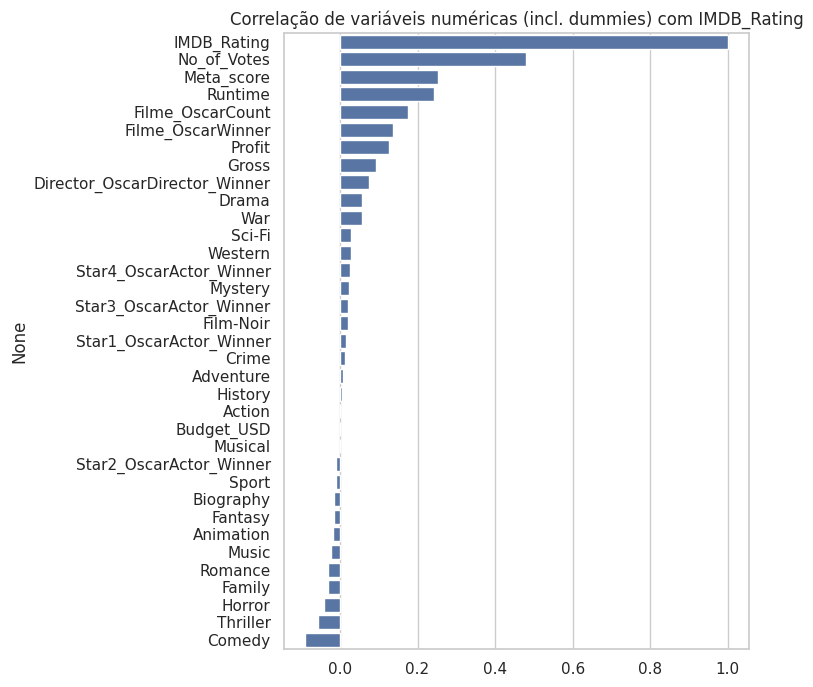

In [88]:
#selecionar todas as colunas numericas
num_cols = tabela.select_dtypes(include='number')

#correlação contra a nota IMDb
corr_target = num_cols.corrwith(tabela['IMDB_Rating']).sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=corr_target.values, y=corr_target.index, orient='h')
plt.title("Correlação de variáveis numéricas (incl. dummies) com IMDB_Rating")
plt.show()

as variáveis que mais se relacionam com a nota do imdb são o número de votos, o meta score e o tempo de duração dos filmes. fatores como bilheteria, orçamento ou até mesmo gêneros específicos aparecem com pouca ou quase nenhuma correlação, mostrando que a recepção do público depende mais de engajamento e avaliação crítica do que de investimento financeiro.

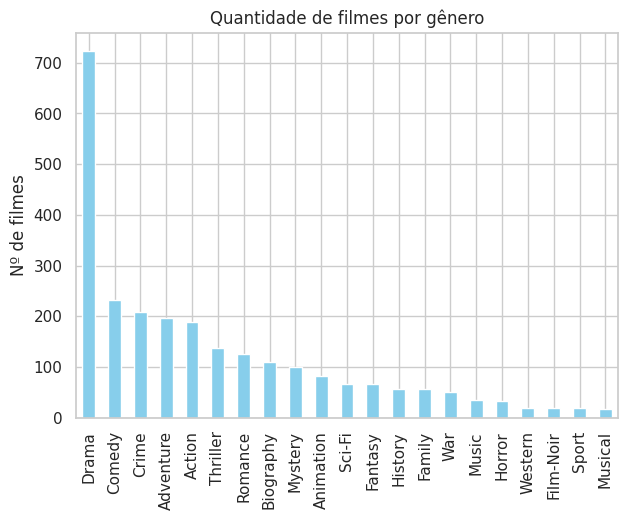

In [89]:
generos = tabela['Genre'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)

generos.plot.bar(color='skyblue')
plt.title("Quantidade de filmes por gênero")
plt.ylabel("Nº de filmes")
plt.show()

o gênero drama domina de longe em quantidade de filmes, seguido por comedy e crime. generos como musical, sport e film-noir aparecem bem pouco, mostrando que sao nichados e muito menos explorados na produçao cinematográfica.

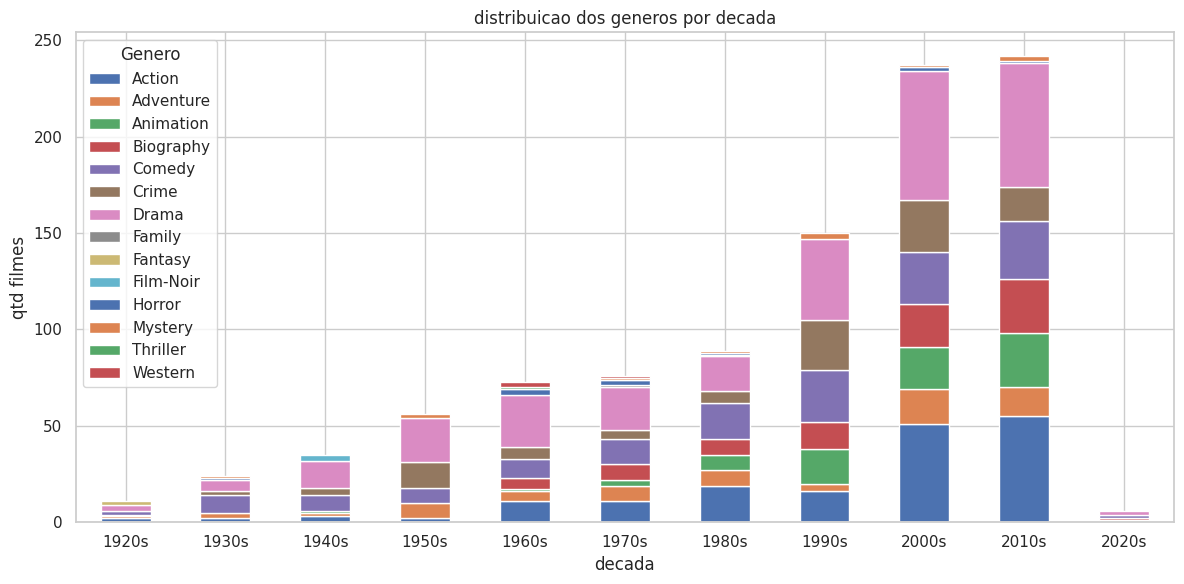

In [90]:
#transformar pra datetime e tirar o ano
anos_temp = pd.to_datetime(tabela["Released_Year"], errors="coerce").dt.year

#criar decada com base nesses anos
decadas_temp = (anos_temp // 10 * 10).astype("Int64").astype(str) + "s"

#pegar o genero principal antes da virgula
generos_temp = tabela["Genre"].astype(str).str.split(",").str[0].str.strip()

#criar dataframe temporario
temp = pd.DataFrame({"Decada": decadas_temp, "Genero": generos_temp})

#tirar linhas com decada nula
temp = temp[temp["Decada"].notna()]

#agrupar por decada e genero
genero_por_decada = temp.groupby(["Decada", "Genero"]).size().unstack(fill_value=0)

#ordenar decadas certinho
genero_por_decada.index = genero_por_decada.index.str.replace("s", "").astype(int)
genero_por_decada = genero_por_decada.sort_index()
genero_por_decada.index = genero_por_decada.index.astype(str) + "s"

#plotar grafico
genero_por_decada.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("distribuicao dos generos por decada")
plt.xlabel("decada")
plt.ylabel("qtd filmes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


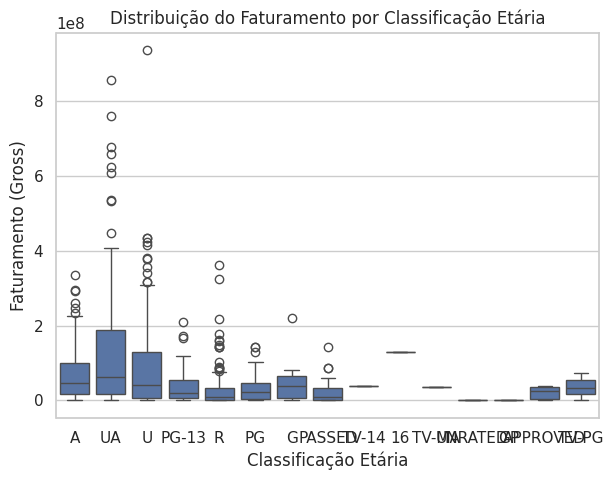

In [91]:
#boxplot de Gross por classificação etaria
sns.boxplot(data=tabela, x='Certificate', y='Gross')
plt.title("Distribuição do Faturamento por Classificação Etária")
plt.xlabel("Classificação Etária")
plt.ylabel("Faturamento (Gross)")
plt.show()

os filmes com classificacao A, UA e U sao os que mais se destacam em faturamento, chegando a bilheterias muito altas em alguns casos. ja os de classificacao PG, R e outras costumam render menos, mostrando que produções mais acessiveis pro publico amplo tendem a ter melhor desempenho financeiro.

# **Hipóteses**

## Será que Adventure + Action, além de terem alto faturamento quando analisados separadamente, também mantêm ou melhoram seu desempenho em termos de avaliação no IMDb quando aparecem combinados?

os resultados mostram que adventure e action isolados ou combinados não apresentam diferença significativa nas notas do público (imdb), ficando todos em torno de 7.9. no entanto, quando olhamos para o faturamento, esses gêneros se destacam fortemente: adventure+action tem média de bilheteria mais que o dobro dos demais, mostrando grande poder comercial. já ao adicionar o drama, a nota média do imdb sobe para 8.15, a maior entre os grupos, embora essa diferença não tenha sido estatisticamente significativa, sugerindo apenas uma tendência. do lado da crítica especializada (meta_score), encontramos diferenças claras: filmes de action puro recebem avaliações mais baixas (~72), enquanto adventure e especialmente adventure+action+drama chegam perto de 80 pontos, sendo os mais valorizados pelos críticos. em resumo, adventure+action é a combinação mais lucrativa, mas adventure+action+drama tende a reunir melhor avaliação tanto do público quanto da crítica.

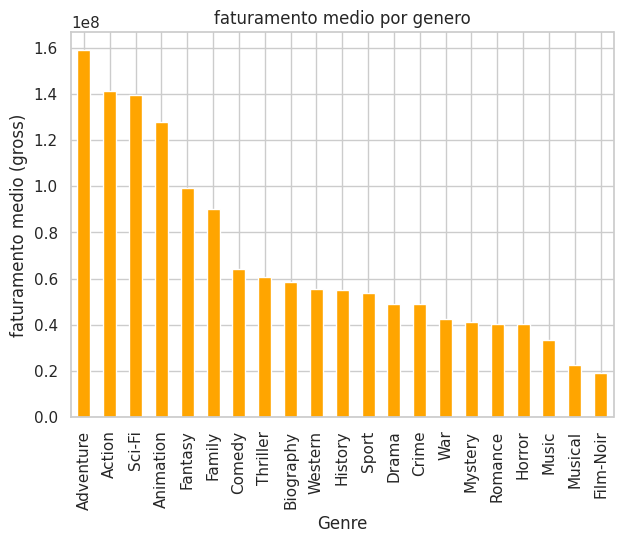

In [92]:
#separar generos em linha
tabela_exploded = tabela.assign(Genre=tabela["Genre"].str.split(", ")).explode("Genre")

#organizar faturamento medio por genero
media_gross = tabela_exploded.groupby("Genre")["Gross"].mean().sort_values(ascending=False)

#grafico
media_gross.plot.bar(color="orange")
plt.title("faturamento medio por genero")
plt.ylabel("faturamento medio (gross)")
plt.show()

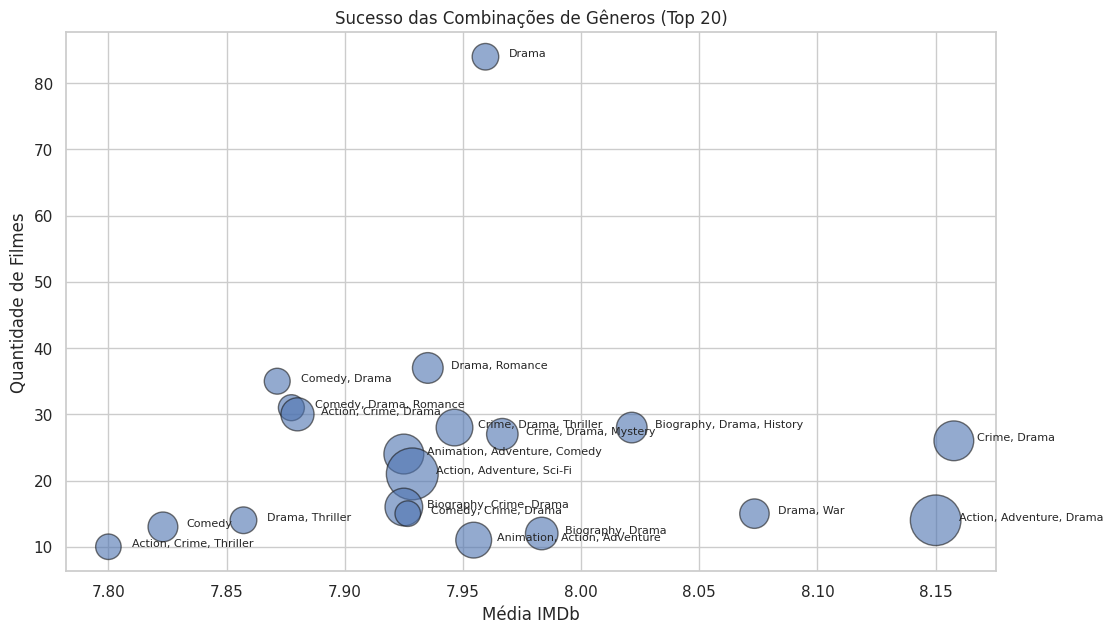

In [93]:
# Agrupar combinações
combo_stats = tabela.groupby('Genre').agg(
    qtd_filmes=('IMDB_Rating', 'count'),
    media_rating=('IMDB_Rating', 'mean'),
    media_votos=('No_of_Votes', 'mean')
).reset_index()

# Pegar só as 20 combinações mais frequentes
top_combos = combo_stats.sort_values('qtd_filmes', ascending=False).head(20)

# Gráfico de bolhas
plt.figure(figsize=(12,7))
plt.scatter(
    top_combos['media_rating'], 
    top_combos['qtd_filmes'], 
    s=top_combos['media_votos']/500,  # bolha proporcional à popularidade
    alpha=0.6, edgecolors="k"
)

# Nome das combinações ao lado das bolhas
for i, row in top_combos.iterrows():
    plt.text(row['media_rating']+0.01, row['qtd_filmes'], row['Genre'], fontsize=8)

plt.xlabel("Média IMDb")
plt.ylabel("Quantidade de Filmes")
plt.title("Sucesso das Combinações de Gêneros (Top 20)")
plt.show()

In [94]:
# criar coluna de grupo baseado nos gêneros
def classifica_genero(row):
    genres = str(row['Genre'])  # ou a coluna que junta os gêneros
    if 'Adventure' in genres and 'Action' in genres:
        return 'Adventure+Action'
    elif 'Adventure' in genres:
        return 'Adventure'
    elif 'Action' in genres:
        return 'Action'
    else:
        return 'Outros'

tabela['Grupo_Genero'] = tabela.apply(classifica_genero, axis=1)

# criar listas com as notas IMDb por grupo
ratings_adventure = tabela.loc[tabela['Grupo_Genero'] == 'Adventure', 'IMDB_Rating']
ratings_action = tabela.loc[tabela['Grupo_Genero'] == 'Action', 'IMDB_Rating']
ratings_both = tabela.loc[tabela['Grupo_Genero'] == 'Adventure+Action', 'IMDB_Rating']
ratings_outros = tabela.loc[tabela['Grupo_Genero'] == 'Outros', 'IMDB_Rating']

# 3) ANOVA
F, p = f_oneway(ratings_adventure, ratings_action, ratings_both, ratings_outros)
print(f"ANOVA: F = {F:.3f} | p-valor = {p:.4f}")

# 4)medias por grupo 
print(tabela.groupby('Grupo_Genero')['IMDB_Rating'].mean())


ANOVA: F = 0.303 | p-valor = 0.8230
Grupo_Genero
Action              7.933019
Adventure           7.939823
Adventure+Action    7.968675
Outros              7.949067
Name: IMDB_Rating, dtype: float64


In [95]:
#separar grupos de faturamento
gross_adventure = tabela.loc[tabela['Grupo_Genero'] == 'Adventure', 'Gross']
gross_action = tabela.loc[tabela['Grupo_Genero'] == 'Action', 'Gross']
gross_both = tabela.loc[tabela['Grupo_Genero'] == 'Adventure+Action', 'Gross']
gross_outros = tabela.loc[tabela['Grupo_Genero'] == 'Outros', 'Gross']

# ANOVA para faturamento
F, p = f_oneway(gross_adventure, gross_action, gross_both, gross_outros)
print(f"ANOVA (Gross): F = {F:.3f} | p-valor = {p:.4f}")

# medias para interpretação
print(tabela.groupby('Grupo_Genero')['Gross'].mean())


ANOVA (Gross): F = 116.009 | p-valor = 0.0000
Grupo_Genero
Action              7.991307e+07
Adventure           1.142431e+08
Adventure+Action    2.195100e+08
Outros              4.080764e+07
Name: Gross, dtype: float64


In [96]:
#função para classificar gêneros
def classifica_genero_v2(row):
    genres = str(row['Genre'])
    if all(g in genres for g in ['Adventure','Action','Drama']):
        return 'Adventure+Action+Drama'
    elif 'Adventure' in genres and 'Action' in genres:
        return 'Adventure+Action'
    elif 'Adventure' in genres:
        return 'Adventure'
    elif 'Action' in genres:
        return 'Action'
    else:
        return 'Outros'

tabela['Grupo_Genero_v2'] = tabela.apply(classifica_genero_v2, axis=1)

#separar listas de notas IMDb
ratings_groups = [g['IMDB_Rating'].values 
                  for _, g in tabela.groupby('Grupo_Genero_v2') if len(g) > 1]

#ANOVA
F, p = f_oneway(*ratings_groups)
print(f"ANOVA (IMDb): F = {F:.3f} | p-valor = {p:.4f}")

#medias para interpretação
print(tabela.groupby('Grupo_Genero_v2')['IMDB_Rating'].mean())


ANOVA (IMDb): F = 2.104 | p-valor = 0.0783
Grupo_Genero_v2
Action                    7.933019
Adventure                 7.939823
Adventure+Action          7.931884
Adventure+Action+Drama    8.150000
Outros                    7.949067
Name: IMDB_Rating, dtype: float64


In [97]:
#separar grupos de Meta_score
meta_adventure = tabela.loc[tabela['Grupo_Genero_v2'] == 'Adventure', 'Meta_score']
meta_action = tabela.loc[tabela['Grupo_Genero_v2'] == 'Action', 'Meta_score']
meta_both = tabela.loc[tabela['Grupo_Genero_v2'] == 'Adventure+Action', 'Meta_score']
meta_both_drama = tabela.loc[tabela['Grupo_Genero_v2'] == 'Adventure+Action+Drama', 'Meta_score']
meta_outros = tabela.loc[tabela['Grupo_Genero_v2'] == 'Outros', 'Meta_score']

#ANOVA para Meta_score
F, p = f_oneway(meta_adventure, meta_action, meta_both, meta_both_drama, meta_outros)
print(f"ANOVA (Meta_score): F = {F:.3f} | p-valor = {p:.4f}")

#medias para interpretação
print(tabela.groupby('Grupo_Genero_v2')['Meta_score'].mean())


ANOVA (Meta_score): F = 9.266 | p-valor = 0.0000
Grupo_Genero_v2
Action                    72.621984
Adventure                 79.713215
Adventure+Action          74.553496
Adventure+Action+Drama    79.958541
Outros                    78.757676
Name: Meta_score, dtype: float64


## Filmes com maior duração (runtime) possuem maiores notas IMB.

Filmes com maior duração tendem a ter notas um pouco mais altas no imdb, mas a relação não é muito forte. ainda assim, da pra ver que produções mais longas costumam ser melhor avaliadas em média.filmes mais longos costumam ter notas um pouco melhores no imdb (r=0.243, p=0.0000) e também tendem a faturar mais (r=0.136, p=0.0000), embora as duas relações sejam fracas. isso mostra que a duração ajuda, mas não é fator decisivo pro sucesso.

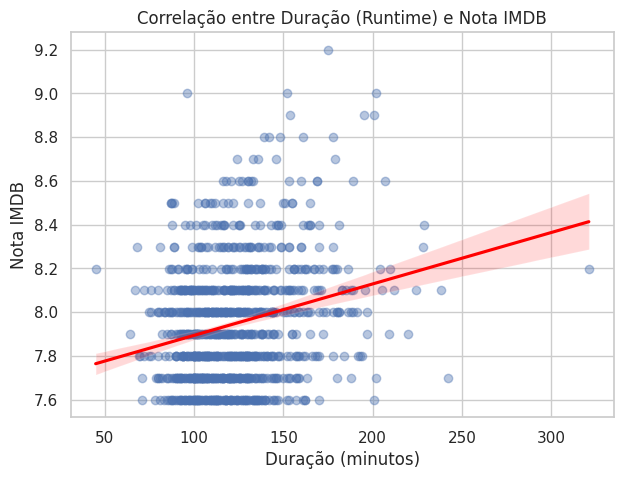

In [98]:
plt.figure(figsize=(7,5))
sns.regplot(
    data=tabela,
    x='Runtime', y='IMDB_Rating',
    scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
)
plt.title("Correlação entre Duração (Runtime) e Nota IMDB")
plt.xlabel("Duração (minutos)")
plt.ylabel("Nota IMDB")
plt.show()


In [99]:
# correlação entre duração e nota
mask = tabela['Runtime'].notna() & tabela['IMDB_Rating'].notna()
r_rating, p_rating = pearsonr(tabela.loc[mask, 'Runtime'], tabela.loc[mask, 'IMDB_Rating'])
print(f"Correlação Runtime × Nota IMDB: r={r_rating:.3f}, p={p_rating:.4f}")

# correlação entre duração e faturamento
mask = tabela['Runtime'].notna() & tabela['Gross'].notna()
r_gross, p_gross = pearsonr(tabela.loc[mask, 'Runtime'], tabela.loc[mask, 'Gross'])
print(f"Correlação Runtime × Faturamento: r={r_gross:.3f}, p={p_gross:.4f}")

Correlação Runtime × Nota IMDB: r=0.243, p=0.0000
Correlação Runtime × Faturamento: r=0.136, p=0.0000


## Combinações de atores que possuem Oscar influencia na nota? (Quanto maior for o quadro de artistas com Oscar, melhor a avaliação)

Ter mais atores vencedores do oscar no elenco não muda de forma significativa a nota do imdb. a correlação é praticamente nula (r = 0.019, p = 0.55) e a anova também confirma que não há diferença estatística entre os grupos (p = 0.80). na prática, filmes com ou sem grandes premiados no elenco ficam com médias muito parecidas, perto de 8.0.

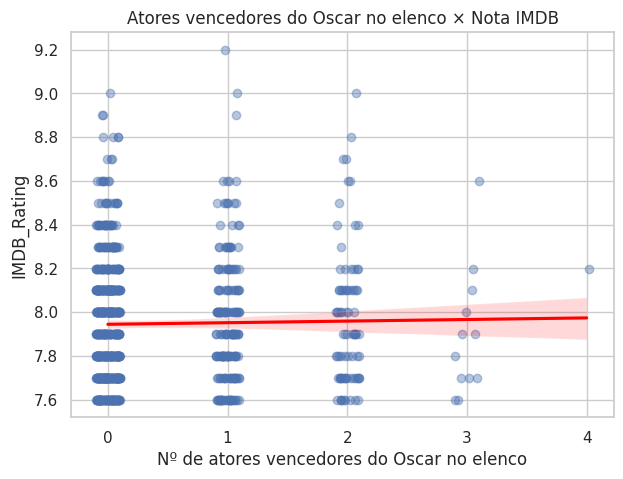

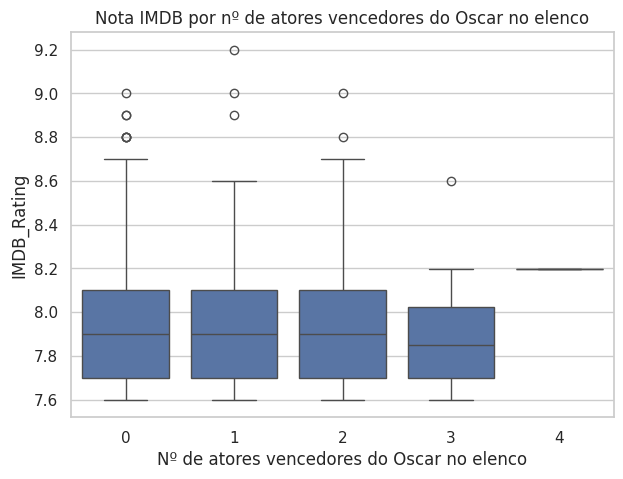

Correlação (Pearson): r = 0.019 | p-valor = 0.5521
   Cast_OscarWinners_Count  IMDB_Rating_mean
0                        0          7.944556
1                        1          7.953171
2                        2          7.967470
3                        3          7.900000
4                        4          8.200000
ANOVA (diferença entre grupos): F = 0.33 | p-valor = 0.8062


In [100]:
#contar vencedores do Oscar no elenco
star_flags = [c for c in ['Star1_OscarActor_Winner', 'Star2_OscarActor_Winner', 'Star3_OscarActor_Winner', 'Star4_OscarActor_Winner'] if c in tabela.columns]

tabela['Cast_OscarWinners_Count'] = tabela[star_flags].sum(axis=1)

# gáficos para inspeção
plt.figure(figsize=(7,5))
sns.regplot(
    data=tabela,
    x='Cast_OscarWinners_Count', y='IMDB_Rating',
    x_jitter=0.1,
    scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
)
plt.title("Atores vencedores do Oscar no elenco × Nota IMDB")
plt.xlabel("Nº de atores vencedores do Oscar no elenco")
plt.ylabel("IMDB_Rating")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(
    data=tabela,
    x='Cast_OscarWinners_Count', y='IMDB_Rating'
)
plt.title("Nota IMDB por nº de atores vencedores do Oscar no elenco")
plt.xlabel("Nº de atores vencedores do Oscar no elenco")
plt.ylabel("IMDB_Rating")
plt.show()

#correlação de Pearson e tabela de médias por contagem
mask = tabela['Cast_OscarWinners_Count'].notna() & tabela['IMDB_Rating'].notna()
r, p = pearsonr(tabela.loc[mask, 'Cast_OscarWinners_Count'], tabela.loc[mask, 'IMDB_Rating'])
print(f"Correlação (Pearson): r = {r:.3f} | p-valor = {p:.4f}")

mean_by_count = (
    tabela.groupby('Cast_OscarWinners_Count', as_index=False)['IMDB_Rating']
          .mean()
          .rename(columns={'IMDB_Rating':'IMDB_Rating_mean'})
          .sort_values('Cast_OscarWinners_Count')
)
print(mean_by_count)

#ANOVA
groups = [g['IMDB_Rating'].values for _, g in tabela.groupby('Cast_OscarWinners_Count') if len(g) > 1]
if len(groups) >= 2:
    F, p_anova = f_oneway(*groups)
    print(f"ANOVA (diferença entre grupos): F = {F:.2f} | p-valor = {p_anova:.4f}")

## Filmes que ganharam mais oscars tem melhores notas imdb? 

sim! enquanto os sem Oscar ficam perto de 7.9, os superpremiados chegam a passar de 8.2, com destaque pros que ganharam 11 Oscars (8.5 de média).
Ou seja: mais Oscar costuma andar junto com mais reconhecimento do público.

Média da nota IMDb por quantidade de Oscars:
Filme_OscarCount
0     7.925377
1     7.934694
2     8.007018
3     8.027027
4     8.048485
5     8.166667
6     8.133333
7     8.225000
8     7.950000
9     7.900000
11    8.500000
12    7.800000
Name: IMDB_Rating, dtype: float64


/tmp/ipykernel_5827/903175745.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Filme_OscarCount', y='IMDB_Rating', data=tabela, palette="Blues")


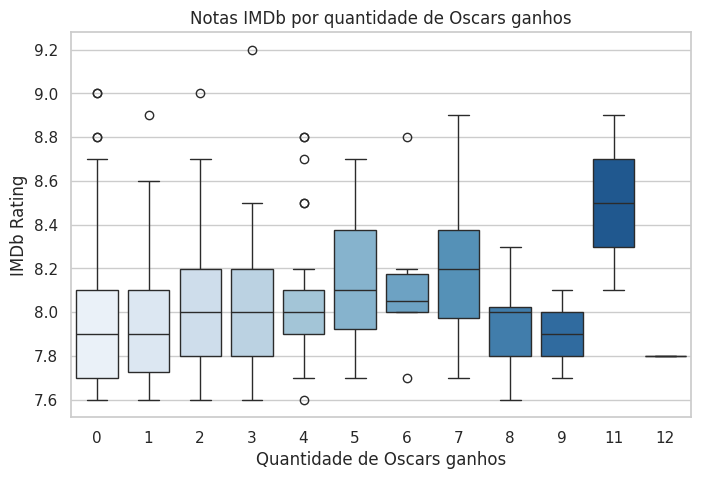

In [101]:
#agrupar IMDb por quantidade de oscars
oscar_vs_rating = tabela.groupby('Filme_OscarCount')['IMDB_Rating'].mean()

print("Média da nota IMDb por quantidade de Oscars:")
print(oscar_vs_rating)

#boxplot para ver distribuição
plt.figure(figsize=(8,5))
sns.boxplot(x='Filme_OscarCount', y='IMDB_Rating', data=tabela, palette="Blues")
plt.title("Notas IMDb por quantidade de Oscars ganhos")
plt.xlabel("Quantidade de Oscars ganhos")
plt.ylabel("IMDb Rating")
plt.show()


# Perguntas

## a - Qual filme você recomendaria para uma pessoa que você não conhece?

O filme que eu indicaria é o "**the dark knight**". Apesar de ele ter um IMDb menor em 0.2 pontos que o "the godfather", quando comparamos o no_of_votes vemos que "tha dark knight"tem maior número. Para poder rankear foi realizada uma multiplicação entre o IMDb e o Log do No_of_votes e assim, podemos perceber que em ranking o "**the dark knight**' está melhor colocado. Outro fator importante é a classificação indicativa, se a pessoa é desconhecida eu não sei a idade dela, então um filme com UA de classificação é mais "leve" que um filme A (corresponderia ao +18 no Brasil).

In [102]:
#criar uma metrica de ranking
# aqui pego a nota e multiplico pelo log do numero de votos

tabela["Ranking_Score"] = tabela["IMDB_Rating"] * np.log1p(tabela["No_of_Votes"])

#ordenar pela metrica
top_filmes = tabela.sort_values(by="Ranking_Score", ascending=False).head(10)

print(top_filmes[["Series_Title", "IMDB_Rating", "No_of_Votes", "Ranking_Score", "Certificate"]])


                                         Series_Title  IMDB_Rating   
1                                     the dark knight          9.0  \
0                                       the godfather          9.2   
5                                        pulp fiction          8.9   
7                                           inception          8.8   
4       the lord of the rings: the return of the king          8.9   
8                                          fight club          8.8   
10                                       forrest gump          8.8   
9   the lord of the rings: the fellowship of the ring          8.8   
2                              the godfather: part ii          9.0   
13                                         the matrix          8.7   

    No_of_Votes  Ranking_Score Certificate  
1       2303232     131.848419          UA  
0       1620367     131.543107           A  
5       1826188     128.317902           A  
7       2067042     127.966341          UA  
4   

## b - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

O faturamento se mostra mais associado a gêneros de apelo comercial como aventura, ação e ficção científica, além de ganhar impulso com filmes mais longos e lançados mais recentemente. Em contrapartida, dramas e romances tendem a reduzir o potencial de bilheteria.

In [103]:
y = pd.to_numeric(tabela['Gross'], errors='coerce')

from scipy.stats import spearmanr
features = {}
features['Released_Year'] = pd.to_datetime(tabela['Released_Year'], errors='coerce').dt.year
features['Runtime'] = pd.to_numeric(tabela['Runtime'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')

genero_cols = [
    "Action","Adventure","Animation","Biography","Comedy","Crime","Drama","Family",
    "Fantasy","Film-Noir","History","Horror","Music","Musical","Mystery","Romance",
    "Sci-Fi","Sport","Thriller","War","Western"
]
for c in genero_cols:
    if c in tabela.columns:
        features[c] = pd.to_numeric(tabela[c], errors='coerce')

corr = {}
for name, col in features.items():
    r, _ = spearmanr(col, y, nan_policy='omit')
    corr[name] = r

for k, v in sorted(corr.items(), key=lambda kv: abs(kv[1]), reverse=True)[:15]:
    print(f"{k}: {v:.4f}")

Adventure: 0.3447
Action: 0.2827
Drama: -0.2407
Runtime: 0.1474
Released_Year: 0.1417
Sci-Fi: 0.1365
Romance: -0.1307
Animation: 0.1213
Music: -0.0866
Biography: 0.0762
Mystery: -0.0748
Crime: -0.0737
Film-Noir: -0.0724
Musical: -0.0601
Family: 0.0592


## c- Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


Com TF-IDF do Overview e regressão logística one-vs-rest obtivemos F1 micro ≈ 0,48 e F1 macro ≈ 0,14. Isso indica que o Overview pode prever gênero para as classes mais comuns, mas não é suficiente para bons resultados em gêneros raros sem ajustes adicionais.

In [104]:
# Contar palavras mais comuns nos overviews
cv = CountVectorizer(stop_words="english", max_features=20)
X_counts = cv.fit_transform(tabela["Overview"].fillna(""))

word_freq = pd.DataFrame({
    "word": cv.get_feature_names_out(),
    "freq": X_counts.toarray().sum(axis=0)
}).sort_values(by="freq", ascending=False)

print(word_freq)

        word  freq
19     young   132
10       man   119
8       life   111
17     world    85
11       new    73
14       war    66
2     family    66
16     woman    65
13     story    63
9       love    61
12       old    54
4      finds    47
1        boy    46
7       help    45
3     father    45
15      wife    44
6       girl    42
0   american    40
5    friends    39
18      year    39


In [105]:
# Dados
X_text = tabela["Overview"].fillna("")
y = tabela[genre_cols]

# TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=10000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X_text)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modelos
modelos = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=-1)),
    "NaiveBayes": OneVsRestClassifier(MultinomialNB()),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=300, max_depth=15, n_jobs=-1, random_state=42))
}

# Avaliação
for nome, modelo in modelos.items():
    print(f"\n===== {nome} =====")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"F1 micro: {f1_score(y_test, y_pred, average='micro'):.4f}")
    print(f"F1 macro: {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))


NameError: name 'MultinomialNB' is not defined

# Explicações

Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Após treinar diferentes modelos, o que apresentou melhor desempenho foi o XGBoost Regressor, alcançando R² de 52,7% e RMSE de 0,191. Esse modelo superou tanto a Regressão Linear Múltipla (R² ≈ 31,3%) quanto o Random Forest (R² ≈ 43,8%). As variáveis utilizadas incluíram popularidade (No_of_Votes), avaliação crítica (Meta_score), características de produção (Runtime, Budget_USD, Gross ou Profit), idioma original e gênero (convertidos em dummies), além de indicadores de premiação de atores/diretor e TF-IDF de palavras-chave (Keywords). Essas transformações foram importantes para capturar informações de diferentes naturezas: numéricas, categóricas e textuais. Por se tratar de um problema de regressão supervisionada, em que a variável alvo (IMDB_Rating) é contínua, optamos por modelos regressivos. Para medir a performance, utilizamos R², que mostra a proporção da variância explicada pelo modelo, complementado por RMSE e MAE, que avaliam a precisão média das previsões.

### Regressão Linear

In [ ]:
#lista de colunas de genero ja existentes no dataset
genero_cols = [
    "Action","Adventure","Animation","Biography","Comedy","Crime","Drama","Family",
    "Fantasy","Film-Noir","History","Horror","Music","Musical","Mystery","Romance",
    "Sci-Fi","Sport","Thriller","War","Western"
]

#criar dummies de idioma (ingles como referencia)
idiomas_dummies = pd.get_dummies(
    tabela["Original_Language"],
    prefix="lang",
    drop_first=True
)

#features escolhidas
X = pd.concat([
    tabela[["Meta_score","No_of_Votes","Runtime"]],
    tabela[genero_cols],
    idiomas_dummies
], axis=1)

#target
y = tabela["IMDB_Rating"]

#split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

#predicao
y_pred = modelo.predict(X_test)

#avaliacao
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

#coeficientes
coef = pd.DataFrame({
    "Variavel": X.columns,
    "Coeficiente": modelo.coef_
}).sort_values(by="Coeficiente", key=abs, ascending=False)

print("\nCoeficientes mais importantes:")
print(coef.head(15))

R²: 0.3993269117862168
RMSE: 0.2156976303877023
MAE: 0.1694349498007005

Coeficientes mais importantes:
   Variavel  Coeficiente
42  lang_nl    -0.564604
28  lang_en    -0.499746
44  lang_ro    -0.495947
33  lang_ga    -0.494552
24  lang_bs    -0.480282
29  lang_es    -0.419872
26  lang_da    -0.417078
52  lang_uz    -0.415417
32  lang_fr    -0.412175
25  lang_cn    -0.366393
48  lang_sv    -0.354430
27  lang_de    -0.353256
45  lang_ru    -0.342942
39  lang_ko    -0.323240
36  lang_it    -0.287011


### Random Forest Regressor

In [ ]:
# Garantir que Released_Year seja numérico (ano)
if np.issubdtype(tabela['Released_Year'].dtype, np.datetime64):
    tabela['Released_Year_Year'] = tabela['Released_Year'].dt.year
else:
    # se já for string/int, força para inteiro seguro
    tabela['Released_Year_Year'] = pd.to_numeric(tabela['Released_Year'].astype(str).str[:4], errors='coerce')

#selecionar features
X_reduced = tabela[['No_of_Votes', 'Meta_score', 'Budget_USD', 'Runtime', 'Gross', 'Released_Year_Year']].fillna(0)
y = tabela['IMDB_Rating']

#treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#random Forest
forest = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=15, min_samples_leaf=2, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#métricas
r2  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("Random Forest")
print("R²:", r2, f"({r2*100:.2f}%)")
print("RMSE:", rmse)
print("MAE:", mae)

Random Forest
R²: 0.5341010324561427 (53.41%)
RMSE: 0.18996437393329632
MAE: 0.149596400200655


### XGBoost

In [ ]:
# garantir ano numérico
if np.issubdtype(tabela['Released_Year'].dtype, np.datetime64):
    tabela['Released_Year_Year'] = tabela['Released_Year'].dt.year
else:
    tabela['Released_Year_Year'] = pd.to_numeric(
        tabela['Released_Year'].astype(str).str[:4], errors='coerce'
    )

# features
X_reduced = tabela[['No_of_Votes', 'Meta_score', 'Budget_USD', 'Runtime', 'Gross', 'Released_Year_Year']].fillna(0)
y = tabela['IMDB_Rating']

# split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# modelo base
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# espaço de busca
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7]
}

# random search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,          # número de combinações testadas (pode aumentar se quiser)
    scoring="r2",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# treino
random_search.fit(X_train, y_train)

# melhor modelo
best_xgb = random_search.best_estimator_
print("Melhores parâmetros:", random_search.best_params_)

# avaliar no teste
y_pred = best_xgb.predict(X_test)
r2  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("\nXGBoost Regressor - RandomizedSearch Otimizado")
print("R²:", r2, f"({r2*100:.2f}%)")
print("RMSE:", rmse)
print("MAE:", mae)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=500, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=500, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=300, subsample=0.6; total tim

In [ ]:
import joblib
joblib.dump(best_xgb, "model.pkl")

# Suposição de filme com características específicas:

Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?


In [ ]:
#dicionário do novo filme
filme_dict = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,  
    'Genre': 'Drama',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469,   
    'Budget_USD': 25000000  ##Esse foi adicionado externamente/manualmente.
}

#criar DataFrame com as colunas usadas no treino
novo_filme = pd.DataFrame([{
    'No_of_Votes': filme_dict['No_of_Votes'],
    'Meta_score': filme_dict['Meta_score'],
    'Budget_USD': filme_dict['Budget_USD'],
    'Runtime': filme_dict['Runtime'],
    'Gross': filme_dict['Gross'],
    'Released_Year_Year': filme_dict['Released_Year_Year']
}])

#fazer a previsão
pred_nota = best_xgb.predict(novo_filme)
print("Nota prevista do IMDB:", round(pred_nota[0], 2))



Nota prevista do IMDB: 8.82


### Teste com o pkl aqui

coloquei apenas as informações do filme que utilizei para o modelo

In [109]:
import joblib
import pandas as pd

# carregar o modelo salvo
modelo = joblib.load("model.pkl")

# dicionário do Shawshank
filme_dict = {
    'No_of_Votes': 2343110,
    'Meta_score': 80.0,
    'Budget_USD': 25000000,
    'Runtime': 142,
    'Gross': 28341469,
    'Released_Year_Year': 1994
}

novo_filme = pd.DataFrame([filme_dict])

# prever
pred = modelo.predict(novo_filme)
print("Nota prevista do IMDb:", round(pred[0], 2))


Nota prevista do IMDb: 8.82


# Adendo

Ao analisar os gráficos temporais percebemos que tem diferença grande no comportamento dos dados nas épocas antes de 1990 . Os dados parecem de outro cenário, tentei usar log achando que ia melhorar a distribuição ficou mais normal, mas no modelo piorou então tirei o log e voltei pro bruto. Pra não cortar os filmes antigos eu coloquei a época dentro do X criei year e year_centered que é year menos 1990, fiz um flag pre1990 pra marcar os mais antigos, também criei interações tipo variável x pre1990 pra deixar o modelo aprender efeitos diferentes antes e depois. marquei quando o meta_score tá faltando porque nos filmes antigos isso acontece mais, gêneros ficaram multi hot mesmo sem tirar coluna porque um filme pode ter mais de um gênero e se tirar perde informação, nos idiomas usei dummies com drop_first porque aqui deu um pouco melhor. No split estratifiquei por faixas de ano pra treino e teste ficarem parecidos, usei pesos por era pra não deixar o pós 1990 pesar demais testei tf idf nas keywords mas trouxe ruído o r² caiu então tirei. No final deixei só o random forest com essas features de época, ficou mais equilibrado entre as épocas e o r² geral ficou ok sem precisar remover os filmes antigos

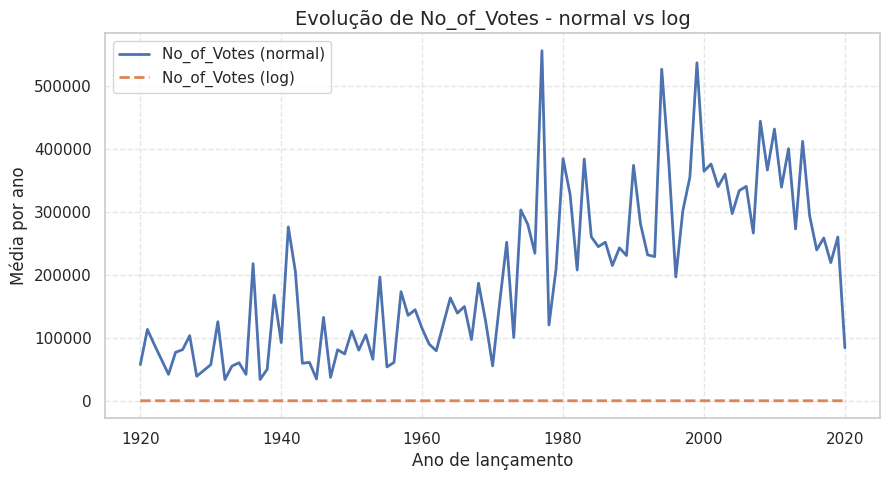

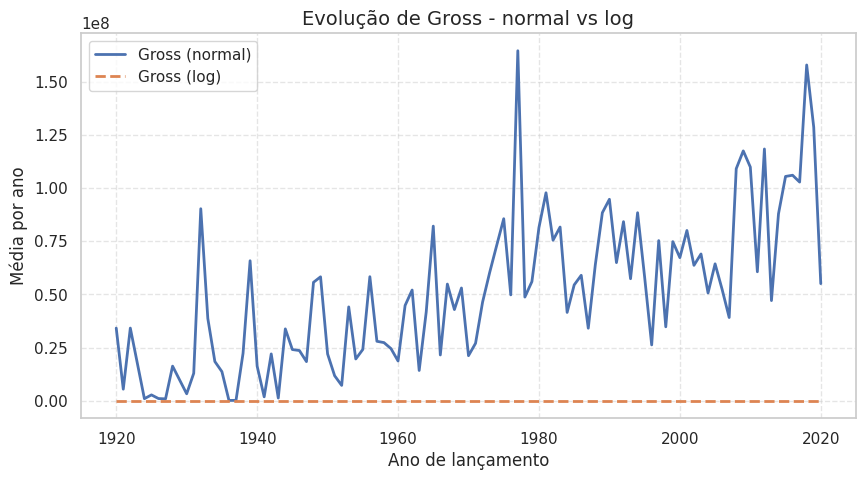

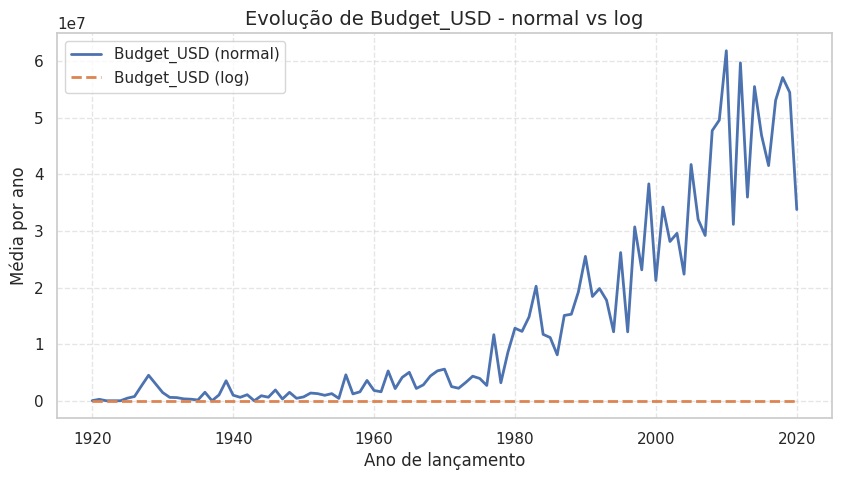

/home/lok/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


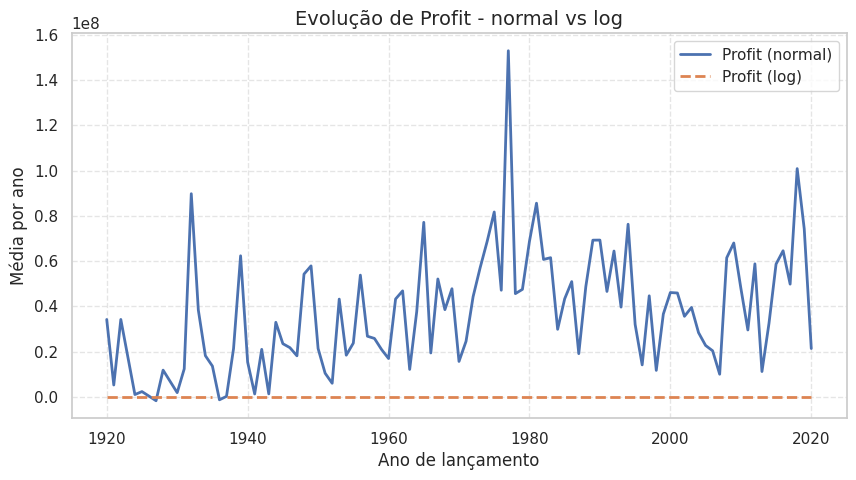

In [ ]:
# garantir Released_Year como int
tabela["Released_Year"] = pd.to_numeric(tabela["Released_Year"], errors="coerce")

# lista de variáveis que quero analisar
vars_to_plot = ["No_of_Votes", "Gross", "Budget_USD", "Profit"]

# loop para cada variável
for col in vars_to_plot:
    # criar versão log
    tabela[col + "_log"] = np.log1p(tabela[col].fillna(0))  # log(1+x) evita log(0)

    # calcular médias por ano
    normal_mean = tabela.groupby("Released_Year")[col].mean()
    log_mean    = tabela.groupby("Released_Year")[col + "_log"].mean()

    # plotar
    plt.figure(figsize=(10,5))
    plt.plot(normal_mean.index, normal_mean.values, label=f"{col} (normal)", linewidth=2)
    plt.plot(log_mean.index, log_mean.values, label=f"{col} (log)", linewidth=2, linestyle="dashed")
    plt.title(f"Evolução de {col} - normal vs log", fontsize=14)
    plt.xlabel("Ano de lançamento")
    plt.ylabel("Média por ano")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [ ]:

def parse_year(s):
    if pd.isna(s): return np.nan
    m = re.search(r"(\d{4})", str(s))
    return int(m.group(1)) if m else np.nan

def coerce_num(series):
    if pd.api.types.is_numeric_dtype(series): 
        return pd.to_numeric(series, errors="coerce")
    x = series.astype(str).str.replace(r"[^0-9\.\-]","", regex=True)
    x = x.replace("", np.nan)
    return pd.to_numeric(x, errors="coerce")

# 1) Ano
if np.issubdtype(tabela['Released_Year'].dtype, np.datetime64):
    tabela['year'] = tabela['Released_Year'].dt.year
else:
    tabela['year'] = tabela['Released_Year'].apply(parse_year)

# 2) Runtime numérico
tabela['Runtime_min'] = tabela['Runtime'].astype(str).str.extract(r'(\d+)').astype(float)

# 3) Budget/Gross numéricos
tabela['Budget_USD_num'] = coerce_num(tabela.get('Budget_USD', np.nan))
tabela['Gross_num']      = coerce_num(tabela.get('Gross', np.nan))

# 4) Indicador de meta_score ausente (pré-1999 sofre mais)
tabela['missing_meta'] = tabela['Meta_score'].isna().astype(int)

# 5) Era e centro
tabela['pre1990']       = (tabela['year'] < 1990).astype(int)
tabela['year_centered'] = (tabela['year'] - 1990).fillna(0)

# 6) Gêneros já existentes (ajusta para só usar os que de fato existem na sua base)
genero_cols = [
    "Action","Adventure","Animation","Biography","Comedy","Crime","Drama","Family",
    "Fantasy","Film-Noir","History","Horror","Music","Musical","Mystery","Romance",
    "Sci-Fi","Sport","Thriller","War","Western"
]
genero_cols = [c for c in genero_cols if c in tabela.columns]

# 7) Idiomas (inglês como referência)
idiomas_dummies = pd.get_dummies(
    tabela['Original_Language'].fillna("NA"),
    prefix="lang", drop_first=True
)

# 8) Base numérica principal
base_num = pd.DataFrame({
    "Meta_score": pd.to_numeric(tabela["Meta_score"], errors="coerce"),
    "No_of_Votes": pd.to_numeric(tabela["No_of_Votes"], errors="coerce"),
    "Runtime_min": tabela["Runtime_min"],
    "Budget_USD_num": tabela["Budget_USD_num"],
    "Gross_num": tabela["Gross_num"],
    "year": tabela["year"],
    "year_centered": tabela["year_centered"],
    "pre1990": tabela["pre1990"],
    "missing_meta": tabela["missing_meta"]
})

# 9) Interações com a era (dão “duas inclinações”)
inter_cols = ["Meta_score","No_of_Votes","Runtime_min","Budget_USD_num","Gross_num","missing_meta"]
for c in inter_cols:
    base_num[f"{c}_x_pre1990"] = base_num[c] * base_num["pre1990"]

# 10) Monta X e y
X = pd.concat([base_num, tabela[genero_cols].fillna(0).astype(int), idiomas_dummies], axis=1)
y = pd.to_numeric(tabela["IMDB_Rating"], errors="coerce")

# Remove linhas sem alvo/ano
mask = (~y.isna()) & (~X['year'].isna())
X, y = X.loc[mask].fillna(0), y.loc[mask]

# ==== SPLIT ESTRATIFICADO POR FAIXAS DE ANO ====
bins = pd.cut(X['year'], [1900,1990,2000,2010,2020,2035], right=False, labels=False, include_lowest=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)

# ==== FUNÇÕES DE MÉTRICA ====
def eval_and_print(name, y_true, y_pred, X_eval):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # métricas por era
    if "pre1990" in X_eval:
        pre_mask  = X_eval["pre1990"]==1
        post_mask = X_eval["pre1990"]==0
        r2_pre  = r2_score(y_true[pre_mask],  y_pred[pre_mask])  if pre_mask.sum()>=5 else np.nan
        r2_post = r2_score(y_true[post_mask], y_pred[post_mask]) if post_mask.sum()>=5 else np.nan
    else:
        r2_pre = r2_post = np.nan

    print(f"\n{name}")
    print(f"R²  = {r2:.4f}")
    print(f"RMSE= {rmse:.4f}")
    print(f"MAE = {mae:.4f}")
    print(f"R² <1990 = {r2_pre:.4f} | R² ≥1990 = {r2_post:.4f}")

# ==== PESOS (OPCIONAL) — balanceia eras sem excluir dados ====
def era_weights(pre1990_series):
    n = len(pre1990_series)
    n_pre  = (pre1990_series==1).sum()
    n_post = n - n_pre
    return np.where(pre1990_series==1, n/(2*max(n_pre,1)), n/(2*max(n_post,1)))

w_train = era_weights(X_train['pre1990'].values)

# ==== 1) RANDOM FOREST ====
rf = RandomForestRegressor(
    random_state=42, n_estimators=300, max_depth=15, min_samples_leaf=2, n_jobs=-1
)

# Sem pesos
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
eval_and_print("RandomForest (sem pesos)", y_test, pred_rf, X_test)

# Com pesos (mesmo código, só passando sample_weight)
rf_w = RandomForestRegressor(
    random_state=42, n_estimators=300, max_depth=15, min_samples_leaf=2, n_jobs=-1
)
rf_w.fit(X_train, y_train, sample_weight=w_train)
pred_rf_w = rf_w.predict(X_test)
eval_and_print("RandomForest (com pesos por era)", y_test, pred_rf_w, X_test)

# ==== 2) REGRESSÃO LINEAR (ou RIDGE) ====
lin = LinearRegression()
# lin = Ridge(alpha=10.0, random_state=42)  # troque para estabilizar coeficientes se quiser

# Sem pesos
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
eval_and_print("Linear (sem pesos)", y_test, pred_lin, X_test)

# Com pesos
lin_w = LinearRegression()
# lin_w = Ridge(alpha=10.0, random_state=42)
lin_w.fit(X_train, y_train, sample_weight=w_train)
pred_lin_w = lin_w.predict(X_test)
eval_and_print("Linear (com pesos por era)", y_test, pred_lin_w, X_test)

# ==== Coeficientes mais importantes (Linear) ====
coef = pd.DataFrame({"Variavel": X.columns, "Coeficiente": lin.coef_}) \
          .assign(abs_coef=lambda d: d["Coeficiente"].abs()) \
          .sort_values("abs_coef", ascending=False)
print("\nCoeficientes (Linear) — Top 15 por |coef|:")
print(coef.head(15)[["Variavel","Coeficiente"]].to_string(index=False))



RandomForest (sem pesos)
R²  = 0.4881
RMSE= 0.1812
MAE = 0.1494
R² <1990 = 0.5703 | R² ≥1990 = 0.4178

RandomForest (com pesos por era)
R²  = 0.4901
RMSE= 0.1808
MAE = 0.1485
R² <1990 = 0.5727 | R² ≥1990 = 0.4197

Linear (sem pesos)
R²  = 0.4610
RMSE= 0.1859
MAE = 0.1422
R² <1990 = 0.6355 | R² ≥1990 = 0.3308

Linear (com pesos por era)
R²  = 0.4521
RMSE= 0.1875
MAE = 0.1424
R² <1990 = 0.6393 | R² ≥1990 = 0.3135

Coeficientes (Linear) — Top 15 por |coef|:
Variavel  Coeficiente
 lang_nl    -0.526032
 lang_en    -0.515780
 lang_es    -0.431979
 lang_uz    -0.426199
 lang_ga    -0.414446
 lang_fr    -0.395410
 lang_bs    -0.377880
 lang_ro    -0.372714
 lang_ru    -0.362350
 lang_da    -0.360935
 lang_zh    -0.359995
 lang_ta     0.359330
 lang_de    -0.357196
 lang_it    -0.356076
 lang_sv    -0.350564


In [ ]:


# ------------ utilitários ------------
def parse_year(s):
    if pd.isna(s): return np.nan
    m = re.search(r"(\d{4})", str(s))
    return int(m.group(1)) if m else np.nan

def coerce_num(series):
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors="coerce")
    x = series.astype(str).str.replace(r"[^0-9\.\-]","", regex=True)
    x = x.replace("", np.nan)
    return pd.to_numeric(x, errors="coerce")

def era_weights(pre1990_series):
    n = len(pre1990_series)
    n_pre  = (pre1990_series==1).sum()
    n_post = n - n_pre
    return np.where(pre1990_series==1, n/(2*max(n_pre,1)), n/(2*max(n_post,1)))

def eval_metrics(y_true, y_pred, X_eval_df):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    pre_mask  = X_eval_df["pre1990"]==1
    post_mask = ~pre_mask
    r2_pre  = r2_score(y_true[pre_mask],  y_pred[pre_mask])  if pre_mask.sum()>=5 else np.nan
    r2_post = r2_score(y_true[post_mask], y_pred[post_mask]) if post_mask.sum()>=5 else np.nan
    return r2, rmse, mae, r2_pre, r2_post

# ------------ engenharia estruturada (igual à sua) ------------
if np.issubdtype(tabela['Released_Year'].dtype, np.datetime64):
    tabela['year'] = tabela['Released_Year'].dt.year
else:
    tabela['year'] = tabela['Released_Year'].apply(parse_year)

tabela['Runtime_min']   = tabela['Runtime'].astype(str).str.extract(r'(\d+)').astype(float)
tabela['Budget_USD_num']= coerce_num(tabela.get('Budget_USD', np.nan))
tabela['Gross_num']     = coerce_num(tabela.get('Gross', np.nan))
tabela['missing_meta']  = tabela['Meta_score'].isna().astype(int)
tabela['pre1990']       = (tabela['year'] < 1990).astype(int)
tabela['year_centered'] = (tabela['year'] - 1990).fillna(0)

genero_cols = [
    "Action","Adventure","Animation","Biography","Comedy","Crime","Drama","Family",
    "Fantasy","Film-Noir","History","Horror","Music","Musical","Mystery","Romance",
    "Sci-Fi","Sport","Thriller","War","Western"
]
genero_cols = [c for c in genero_cols if c in tabela.columns]

base_num = pd.DataFrame({
    "Meta_score": pd.to_numeric(tabela["Meta_score"], errors="coerce"),
    "No_of_Votes": pd.to_numeric(tabela["No_of_Votes"], errors="coerce"),
    "Runtime_min": tabela["Runtime_min"],
    "Budget_USD_num": tabela["Budget_USD_num"],
    "Gross_num": tabela["Gross_num"],
    "year": tabela["year"],
    "year_centered": tabela["year_centered"],
    "pre1990": tabela["pre1990"],
    "missing_meta": tabela["missing_meta"]
})
for c in ["Meta_score","No_of_Votes","Runtime_min","Budget_USD_num","Gross_num","missing_meta"]:
    base_num[f"{c}_x_pre1990"] = base_num[c] * base_num["pre1990"]

y = pd.to_numeric(tabela["IMDB_Rating"], errors="coerce")

# ------------ função que monta X (idiomas drop_first on/off) + opcional TF-IDF(SVD) ------------
def make_design(drop_first_lang: bool, use_text: bool, svd_components: int = 100, min_df: int = 3, ngram=(1,2)):
    # idiomas
    idiomas = pd.get_dummies(
        tabela['Original_Language'].fillna("NA"), prefix="lang", drop_first=drop_first_lang
    )
    X_struct = pd.concat([base_num, tabela[genero_cols].fillna(0).astype(int), idiomas], axis=1)

    # filtra linhas válidas
    mask = (~y.isna()) & (~X_struct['year'].isna())
    X_struct = X_struct.loc[mask].fillna(0)
    y_ok     = y.loc[mask]

    # split estratificado por faixas de ano
    bins = pd.cut(X_struct['year'], [1900,1990,2000,2010,2020,2035],
                  right=False, labels=False, include_lowest=True)
    X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(
        X_struct, y_ok, X_struct.index, test_size=0.2, random_state=42, stratify=bins
    )

    # texto opcional
    if use_text:
        kw = tabela.loc[X_tr.index, 'Keywords'].fillna('').astype(str)
        kw_te = tabela.loc[X_te.index, 'Keywords'].fillna('').astype(str)

        tfidf = TfidfVectorizer(lowercase=True, strip_accents='unicode',
                                ngram_range=ngram, min_df=min_df, max_features=5000)
        X_kw_tr = tfidf.fit_transform(kw)
        X_kw_te = tfidf.transform(kw_te)

        svd = TruncatedSVD(n_components=svd_components, random_state=42)
        X_kw_tr_svd = svd.fit_transform(X_kw_tr)
        X_kw_te_svd = svd.transform(X_kw_te)

        X_tr_mat = np.hstack([X_tr.values, X_kw_tr_svd])
        X_te_mat = np.hstack([X_te.values, X_kw_te_svd])
        feat_names = X_tr.columns.tolist() + [f"kw_svd_{i+1}" for i in range(svd_components)]
        return X_tr, X_te, y_tr, y_te, X_tr_mat, X_te_mat, feat_names
    else:
        return X_tr, X_te, y_tr, y_te, X_tr.values, X_te.values, X_tr.columns.tolist()

# ------------ função que roda RF e retorna métricas + importâncias ------------
def run_rf(X_tr_df, X_te_df, y_tr, y_te, X_tr_mat, X_te_mat, feat_names, use_weights: bool,
           rf_params=None):
    if rf_params is None:
        rf_params = dict(
            random_state=42, n_estimators=300, max_depth=15, min_samples_leaf=2, n_jobs=-1
        )
    rf = RandomForestRegressor(**rf_params)
    if use_weights:
        w = era_weights(X_tr_df['pre1990'].values)
        rf.fit(X_tr_mat, y_tr, sample_weight=w)
    else:
        rf.fit(X_tr_mat, y_tr)

    pred = rf.predict(X_te_mat)
    r2, rmse, mae, r2_pre, r2_post = eval_metrics(y_te, pred, X_te_df)
    imp = pd.DataFrame({'feature': feat_names, 'importance': rf.feature_importances_}) \
            .sort_values('importance', ascending=False)
    return (r2, rmse, mae, r2_pre, r2_post), imp

# ------------ Experimentos ------------
experimentos = []
# A) baseline: sem texto, idiomas drop_first=True (seu antigo)
Xtr, Xte, ytr, yte, Xtrm, Xtem, names = make_design(drop_first_lang=True, use_text=False)
for use_w in [False, True]:
    m, imp = run_rf(Xtr, Xte, ytr, yte, Xtrm, Xtem, names, use_weights=use_w)
    experimentos.append(dict(setup="NoText | drop_first=True | weights=%s" % use_w,
                             R2=m[0], RMSE=m[1], MAE=m[2], R2_pre=m[3], R2_pos=m[4]))

# B) sem texto, idiomas drop_first=False
Xtr, Xte, ytr, yte, Xtrm, Xtem, names = make_design(drop_first_lang=False, use_text=False)
for use_w in [False, True]:
    m, imp = run_rf(Xtr, Xte, ytr, yte, Xtrm, Xtem, names, use_weights=use_w)
    experimentos.append(dict(setup="NoText | drop_first=False | weights=%s" % use_w,
                             R2=m[0], RMSE=m[1], MAE=m[2], R2_pre=m[3], R2_pos=m[4]))

# C) com texto: testar SVD=50 e 100, min_df=5 (menos ruído)
for svd_k in [50, 100]:
    Xtr, Xte, ytr, yte, Xtrm, Xtem, names = make_design(drop_first_lang=False, use_text=True,
                                                        svd_components=svd_k, min_df=5, ngram=(1,2))
    for use_w in [False, True]:
        # hiperparâmetros um pouco mais conservadores para texto
        params = dict(random_state=42, n_estimators=500, max_depth=12,
                      min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
        m, imp = run_rf(Xtr, Xte, ytr, yte, Xtrm, Xtem, names, use_weights=use_w, rf_params=params)
        experimentos.append(dict(setup=f"Text(svd={svd_k},min_df=5) | drop_first=False | weights={use_w}",
                                 R2=m[0], RMSE=m[1], MAE=m[2], R2_pre=m[3], R2_pos=m[4]))

# Resultado compacto
res = pd.DataFrame(experimentos).sort_values('R2', ascending=False)
print(res.to_string(index=False))


                                                    setup       R2     RMSE      MAE   R2_pre   R2_pos
                  NoText | drop_first=True | weights=True 0.490103 0.180830 0.148463 0.572711 0.419693
                 NoText | drop_first=False | weights=True 0.489680 0.180905 0.148536 0.574787 0.417659
                NoText | drop_first=False | weights=False 0.489400 0.180955 0.149235 0.568575 0.421159
                 NoText | drop_first=True | weights=False 0.488062 0.181192 0.149383 0.570252 0.417850
 Text(svd=50,min_df=5) | drop_first=False | weights=False 0.350941 0.204020 0.165630 0.391958 0.302302
  Text(svd=50,min_df=5) | drop_first=False | weights=True 0.350093 0.204153 0.165722 0.394609 0.299189
 Text(svd=100,min_df=5) | drop_first=False | weights=True 0.300496 0.211799 0.172273 0.349086 0.245275
Text(svd=100,min_df=5) | drop_first=False | weights=False 0.300110 0.211858 0.172208 0.346058 0.246564


weights=True é quando está aplicado os pesos, false é sem. 